In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
#    Define your Dataset    
sADF=pd.read_csv(r"Site A - Tue Feb 15 2022 to Thu Jun 30 2022.csv")
sBDF=pd.read_csv(r"Site B - Tue Feb 15 2022 to Thu Jun 30 2022.csv")

In [18]:
def IdentifyEvents(df,dry_hours_skip,moving_hours):
    #  This method use moving STD (std_mov) (last (moving_hours) hours) for start and end of an event
    # For the start of an event use: std_mov > *8 percent of range of std_mov 
    # To detect the end of an event use: std_mov < 3 percentage of range of std_mov
    
    skip=int(dry_hours_skip*(60/5))    # (dry_hours_skip) hours of no significant change in water level means start of another event
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    
    # +++++++++++ this part calculates the moving STD  ++++++++++
    
    std_mov=moving_std(df,moving_hours)      # calculates STD of last (moving_hours) hours
    
    # ???????????? This part set the threshold for START and END of an event  ??????????????
    
    rng3p=np.max(std_mov)*(3/100)            # 3 percent of the range of moving STD
    rng8p=np.max(std_mov)*(7.5/100)          # 7.5 percent of the range of moving STD
    
    
    
    # ++++++++++++++++ This part identify the rainfall events  ++++++++++++++++
    
    nre=True     #indicator if the current time falls under "No Rain Event" or not
    # rpc=0
    #dpc=0
    start_time=[]
    end_time=[]
    start_index=[]
    end_index=[]
    #duration=[]
    i=1
    while i<df.shape[0]-1:
        if std_mov[i]>=rng8p:
            if nre==True:
                # This is a new rainfall event
                start_time.append(df["Timestamp"][df.index.to_list()[0]+i])
                start_index.append(df.index.to_list()[0]+i)
                nre=False
                i+=1
            while std_mov[i]>rng3p:
                i+=1
            if np.max(std_mov[i+1:i+skip+1])<rng8p:
                # dry period starts from index i+1
                end_time.append(df["Timestamp"][df.index.to_list()[0]+i])
                end_index.append(df.index.to_list()[0]+i)
                nre=True
                i=i+skip
        i+=1
    
    # ++++++++++++++ This part finds wellflood duration and drawdown rates +++++++++++++
    
    wf_d=[]      # Wellflood duration for an event
    max_wl=[]    # Max water level
    dd_d=[]      # drawdown durations
    dd_l=[]      # drawdown levels
    dd_r=[]      # drawdown rates
    dd_r_ave=[]  # average drawdown rate within an event
    for event in range(np.size(start_index)):
        wfd,e_dd,e_dl,e_dr,start=drawdown_wellflood_event(df,wl_mm,event,start_index,end_index)
        wf_d.append(wfd)
        max_wl.append(np.max(wl_mm[start_index[event]:end_index[event]+1]))    # max water level for each event
        dd_r_ave.append(np.average(e_dr))
        dd_d=np.append(dd_d,e_dd)
        dd_l=np.append(dd_l,e_dl)
        dd_r=np.append(dd_r,e_dr)
        #print(np.size(dd_r))  
    return start_time,end_time,start_index,end_index,np.subtract(end_index,start_index),max_wl,wf_d,dd_r_ave,dd_r,wl_mm,rng8p,rng3p

def drawdown_wellflood_event(df,wlevel_mm,index,start_index,end_index):
    #index=i
    max_mov=moving_max(df[start_index[index]:end_index[index]],0.5)
    #std_mov=moving_std(df[start_indexA[index]:end_indexA[index]],0.5)
    wl=wlevel_mm[start_index[index]:end_index[index]+1]
    
    # ++++++  Wellflood Duration within an event  ++++++
    
    # ???????????   Well flood happens when water level is above 5% of min waterlevel within an event
    c=0
    for j in wl:
        if j>=np.min(wl)+(np.max(wl)-np.min(wl))*0.05:     
            c+=1
    wfd=c*(5/60)     #measured in hours
    
    # ++++++++++  finding peak and bottom from an event (there could be multiple drawdowns) ++++++++
    
    start=[]
    end=[]
    i=1
    while i <np.size(wl)-1:
        if max_mov[i]-wl[i]>0:
            start.append(i-1)
            while max_mov[i]-wl[i]>0:
                i+=1
                if i>=np.size(wl):
                    break
            end.append(i-1)
        i+=1
    # Discards peaks that's have very small amount of drawdown
    i=0
    while i<np.size(start)-1:
        if abs(wl[start[i]]-wl[end[i]])<150:
            if wl[start[i]]<wl[start[i+1]]:
                start.pop(i)
                end.pop(i)
            else:
                start.pop(i+1)
                end.pop(i)
            continue
        else:
            i+=1
    i=0
    while i<np.size(start)-1:  
        if abs(wl[end[i]]-wl[start[i+1]])<150:
            end.pop(i)
            start.pop(i+1)
            continue
        else:
            i+=1
    # Discard peaks which are very close to each other
    i=0
    while i<np.size(start)-1:
        if (start[i+1]-start[i])<25:
            if wl[start[i+1]]>wl[start[i]]:
                start.pop(i)
                end.pop(i)
            else:
                start.pop(i+1)
                end.pop(i)
            continue
        else:
            i+=1
            
    # +++++++++++ calculates all the drawdown durations, levels and rates within an event +++++++++++
    
    e_dd=[]    # drawdown durations
    e_dl=[]    # drawdown levels
    e_dr=[]    # drawdown rates
    for j in range(np.size(start)):
            dd=((end[j]-start[j])*5)/60        # Measured in hours
            dl=wl[start[j]]-wl[end[j]]    #measured in mm
            dr=dl/dd                      #Measured in mm/hour
            e_dd.append(dd)
            e_dl.append(dl)
            e_dr.append(dr)
    return wfd,e_dd,e_dl,e_dr,start

# Calculate moving STD of last *few hours
def moving_std(df,period_in_hour):      
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    mov_std=[0]
    mean_mov=[wl_mm[0]]
    for i in range(np.size(wl_mm)):
        periods=int(period_in_hour*(60/5))    
        if i<periods:
            mov_std.append(np.std(wl_mm[:i+1]))
            mean_mov.append(np.mean(wl_mm[:i+1]))
        else:
            mov_std.append(np.std(wl_mm[i-periods:i+1]))
            mean_mov.append(np.mean(wl_mm[i-periods:i+1]))
    return mov_std

# Calculate moving MAX of last *few hours
def moving_max(df,period_in_hour):
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    mov_max=[wl_mm[0]]
    for i in range(np.size(wl_mm)):
        periods=int(period_in_hour*(60/5))    
        if i<periods:
            mov_max.append(np.max(wl_mm[:i+1]))
        else:
            mov_max.append(np.max(wl_mm[i-periods:i+1]))
    return mov_max


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


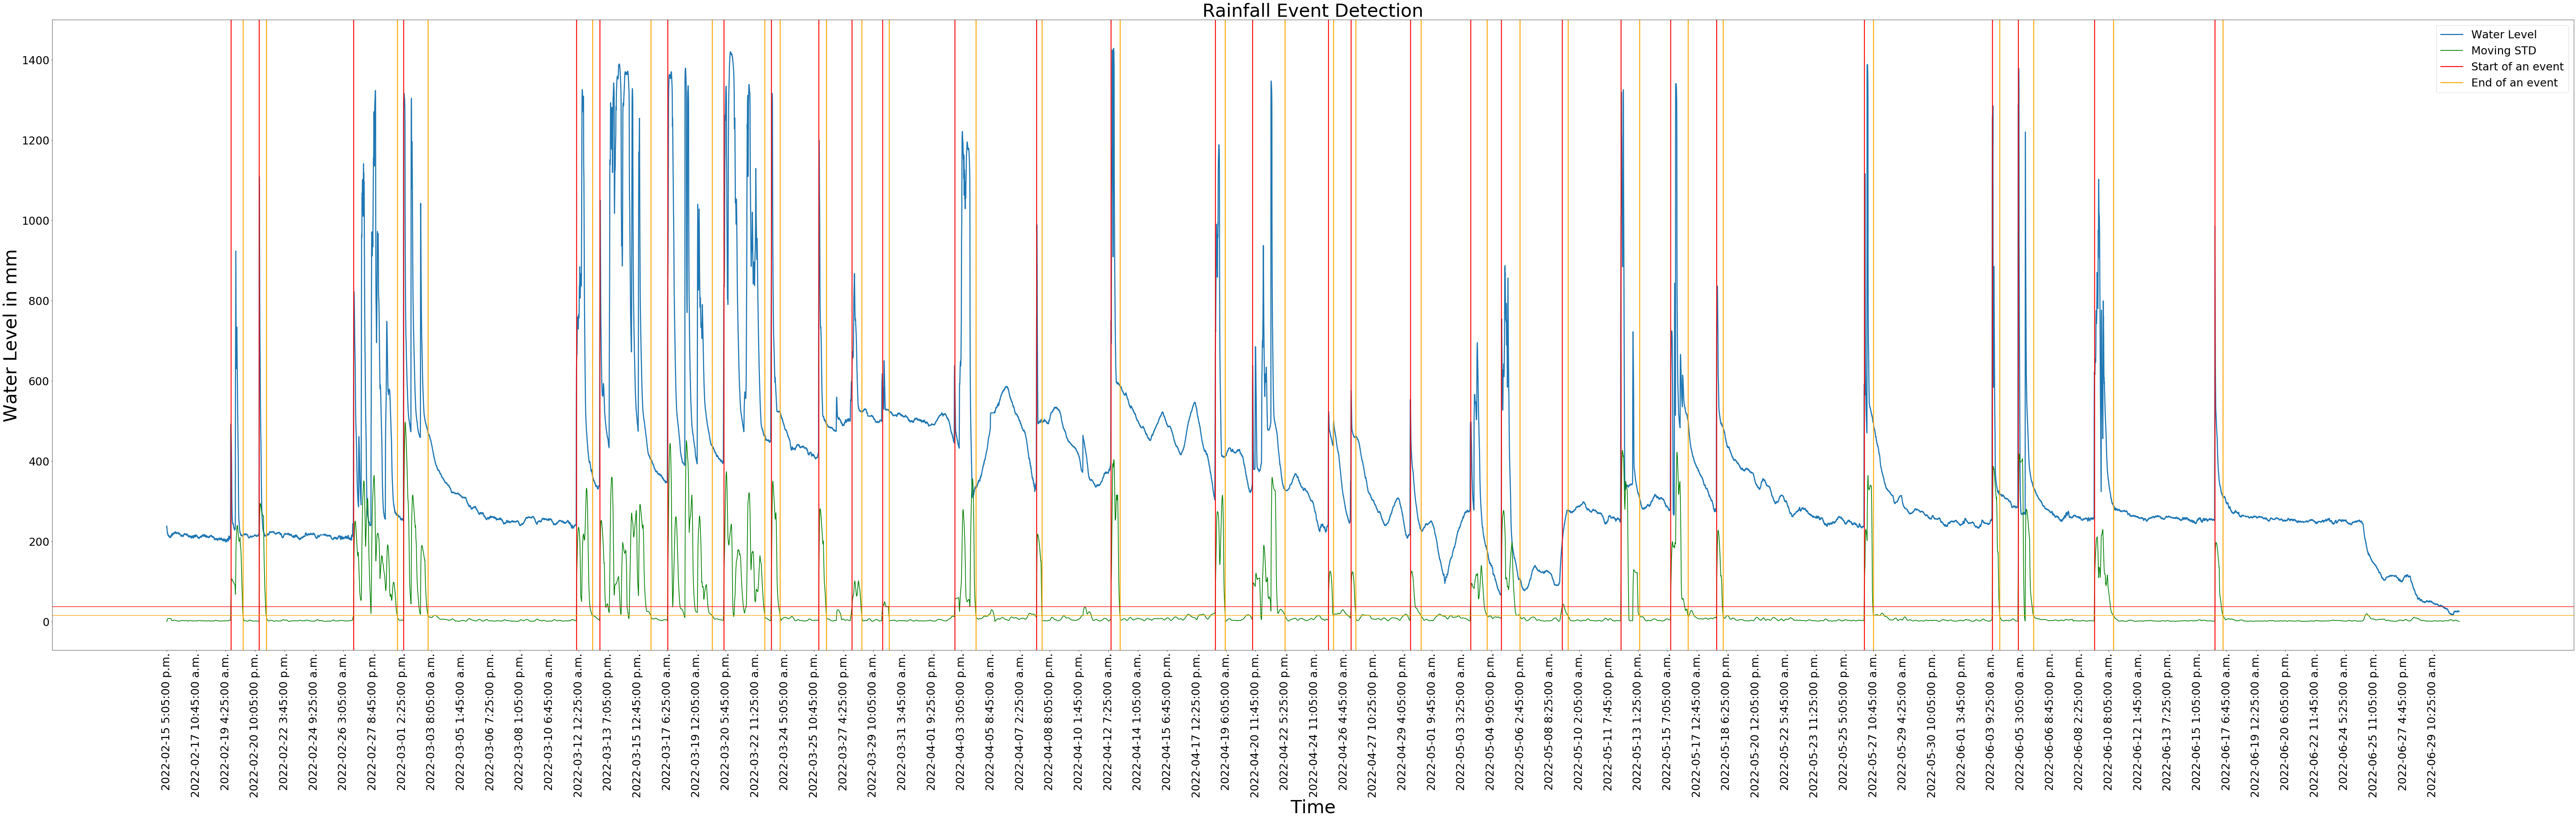

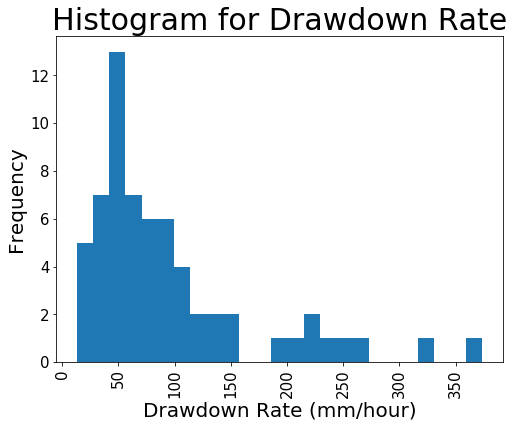

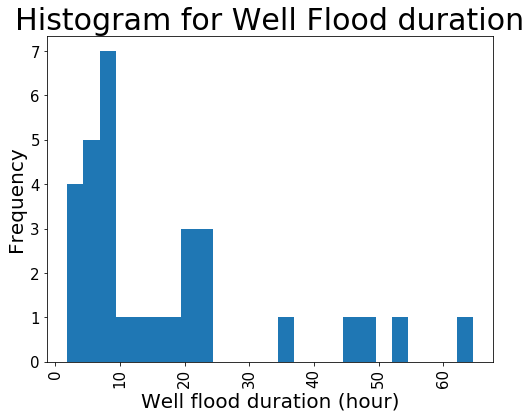

Rainfall_start_time         Rainfall_end_time  Rainfall_start_index  \
0   2022-02-19 11:50:00 a.m.   2022-02-20 5:05:00 a.m.                  1089   
1    2022-02-21 4:05:00 a.m.   2022-02-21 2:05:00 p.m.                  1572   
2    2022-02-26 5:45:00 p.m.   2022-03-01 7:25:00 a.m.                  3176   
3    2022-03-01 4:35:00 p.m.   2022-03-03 3:10:00 a.m.                  4026   
4    2022-03-11 9:15:00 p.m.   2022-03-12 7:55:00 p.m.                  6962   
5    2022-03-13 7:20:00 a.m.   2022-03-16 7:25:00 a.m.                  7359   
6    2022-03-17 7:20:00 a.m.  2022-03-19 10:30:00 p.m.                  8511   
7    2022-03-20 2:50:00 p.m.   2022-03-23 1:00:00 a.m.                  9465   
8    2022-03-23 9:55:00 a.m.  2022-03-23 10:40:00 p.m.                 10270   
9    2022-03-26 5:25:00 a.m.   2022-03-26 4:15:00 p.m.                 11080   
10   2022-03-28 4:30:00 a.m.   2022-03-28 6:15:00 p.m.                 11645   
11  2022-03-29 11:40:00 p.m.   2022-03-30 8:45:00 a.m.                 12163   
12   2022-04-03 5:50:00 a.m.  2022-04-04 11:55:00 a.m.                 13389   
13   2022-04-08 1:45:00 a.m.   2022-04-08 9:25:00 a.m.                 14780   
14  2022-04-12 11:10:00 a.m.  2022-04-12 11:50:00 p.m.                 16045   
15   2022-04-18 2:50:00 p.m.   2022-04-19 4:55:00 a.m.                 17817   
16   2022-04-20 7:40:00 p.m.   2022-04-22 5:40:00 p.m.                 18451   
17   2022-04-25 7:05:00 a.m.   2022-04-25 1:55:00 p.m.                 19740   
18   2022-04-26 3:00:00 p.m.   2022-04-26 9:50:00 p.m.                 20123   
19   2022-04-30 2:55:00 a.m.   2022-04-30 6:15:00 p.m.                 21130   
20   2022-05-03 4:10:00 p.m.   2022-05-04 3:45:00 p.m.                 22153   
21  2022-05-05 12:00:00 p.m.   2022-05-06 2:00:00 p.m.                 22679   
22   2022-05-09 2:10:00 a.m.  2022-05-09 10:15:00 a.m.                 23713   
23   2022-05-12 1:00:00 p.m.   2022-05-13 3:30:00 p.m.                 24707   
24  2022-05-15 11:35:00 a.m.  2022-05-16 12:00:00 p.m.                 25554   
25   2022-05-18 4:40:00 a.m.   2022-05-18 1:55:00 p.m.                 26335   
26   2022-05-26 9:35:00 p.m.  2022-05-27 10:50:00 a.m.                 28842   
27  2022-06-03 10:55:00 a.m.   2022-06-03 9:35:00 p.m.                 31018   
28  2022-06-04 11:30:00 p.m.   2022-06-05 9:30:00 p.m.                 31457   
29  2022-06-09 11:30:00 a.m.   2022-06-10 2:30:00 p.m.                 32753   
30   2022-06-16 2:15:00 p.m.   2022-06-17 1:45:00 a.m.                 34802   

    Rainfall_end_index  Rainfall_duration (periods)  Max WaterLevel(mm)  \
0                 1296                          207               923.0   
1                 1692                          120              1109.0   
2                 3916                          740              1323.0   
3                 4441                          415              1316.0   
4                 7234                          272              1325.0   
5                 8224                          865              1389.0   
6                 9269                          758              1379.0   
7                10163                          698              1420.0   
8                10423                          153              1316.0   
9                11210                          130              1199.0   
10               11810                          165               867.0   
11               12272                          109               650.0   
12               13750                          361              1221.0   
13               14872                           92               989.0   
14               16197                          152              1428.0   
15               17986                          169              1188.0   
16               19003                          552              1347.0   
17               19822                           82               523.0   
18               20205 

In [19]:
#  ------------------- This is a result generation section -----------------------------

#  ++++++++++++++++++++++  Enter the Name of Your Dataset Below +++++++++++++++++++++++++
dataset=sADF

#  +++++++++++++   Choose the value of your parameters
dry_hours_to_skip=6        # in hours
moving_hours_forSTD=6      # in hours



pd.to_datetime(dataset["Timestamp"]);

# This part calculate all rainfall events
start_time,end_time,start_index,end_index,rf_duration,max_wl,wflood_d,drawdownR_ave,drawdown_rates,water_level,startp,endp=IdentifyEvents(dataset,dry_hours_to_skip,moving_hours_forSTD)
rf_event=pd.DataFrame({"Rainfall_start_time":start_time,"Rainfall_end_time":end_time,"Rainfall_start_index":start_index,"Rainfall_end_index":end_index,"Rainfall_duration (periods)":rf_duration,"Max WaterLevel(mm)":max_wl,"WellFlood_duration (hours)":wflood_d,"Avg. Drawdown Rate(mm/hour)":drawdownR_ave})
rf_event


# This draw all data set with events being identified
fig=plt.figure(figsize=(120, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,np.size(water_level),500)])
ax.set_xticklabels([dataset["Timestamp"][i] for i in range(0,np.size(water_level),500)])

wle,=plt.plot(water_level,label='Water Level',linewidth=3)
#plt.plot(mean_mov)
std_mov=moving_std(dataset,moving_hours_forSTD)
mstd,=plt.plot(std_mov,label="Moving STD",linewidth=2,color="green")
for i in start_index:
    st=plt.axvline(x=i, linewidth=2.5,color='r',label="Start of an event")
for i in end_index:
    en=plt.axvline(x=i,linewidth=2.5, color='orange',label="End of an event")
plt.axhline(y=endp, color='orange', linestyle='-')
plt.axhline(y=startp, color='red', linestyle='-')
plt.xlabel('Time',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',handles=[wle,mstd,st,en],fontsize=30)
plt.title("Rainfall Event Detection",fontsize=50)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(drawdown_rates,bins=25)
plt.xlabel('Drawdown Rate (mm/hour)',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.tick_params(axis='x',labelsize=15,rotation=90)
plt.tick_params(axis='y',labelsize=15)
plt.title("Histogram for Drawdown Rate",fontsize=30)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(wflood_d,bins=25)
plt.xlabel("Well flood duration (hour)",fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.tick_params(axis='x',labelsize=15,rotation=90)
plt.tick_params(axis='y',labelsize=15)
plt.title("Histogram for Well Flood duration",fontsize=30)
plt.show()


rf_event

In [1774]:

#Calculate moving MEAN of last *few hours
def moving_mean(df,period_in_hour):
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    mean_mov=[wl_mm[0]]
    for i in range(np.size(wl_mm)):
        periods=int(period_in_hour*(60/5))    
        if i<periods:
            mean_mov.append(np.mean(wl_mm[:i+1]))
        else:
            mean_mov.append(np.mean(wl_mm[i-periods:i+1]))
    return mean_mov



Rainfall_start_time         Rainfall_end_time  Rainfall_start_index  \
0   2022-02-19 11:50:00 a.m.   2022-02-20 5:05:00 a.m.                  1089   
1    2022-02-21 4:05:00 a.m.   2022-02-21 2:05:00 p.m.                  1572   
2    2022-02-26 5:45:00 p.m.   2022-03-01 7:25:00 a.m.                  3176   
3    2022-03-01 4:35:00 p.m.   2022-03-03 3:10:00 a.m.                  4026   
4    2022-03-11 9:15:00 p.m.   2022-03-12 7:55:00 p.m.                  6962   
5    2022-03-13 7:20:00 a.m.   2022-03-16 7:25:00 a.m.                  7359   
6    2022-03-17 7:20:00 a.m.  2022-03-19 10:30:00 p.m.                  8511   
7    2022-03-20 2:50:00 p.m.   2022-03-23 1:00:00 a.m.                  9465   
8    2022-03-23 9:55:00 a.m.  2022-03-23 10:40:00 p.m.                 10270   
9    2022-03-26 5:25:00 a.m.   2022-03-26 4:15:00 p.m.                 11080   
10   2022-03-28 4:30:00 a.m.   2022-03-28 6:15:00 p.m.                 11645   
11  2022-03-29 11:40:00 p.m.   2022-03-30 8:45:00 a.m.                 12163   
12   2022-04-03 5:50:00 a.m.  2022-04-04 11:55:00 a.m.                 13389   
13   2022-04-08 1:45:00 a.m.   2022-04-08 9:25:00 a.m.                 14780   
14  2022-04-12 11:10:00 a.m.  2022-04-12 11:50:00 p.m.                 16045   
15   2022-04-18 2:50:00 p.m.   2022-04-19 4:55:00 a.m.                 17817   
16   2022-04-20 7:40:00 p.m.   2022-04-22 5:40:00 p.m.                 18451   
17   2022-04-25 7:05:00 a.m.   2022-04-25 1:55:00 p.m.                 19740   
18   2022-04-26 3:00:00 p.m.   2022-04-26 9:50:00 p.m.                 20123   
19   2022-04-30 2:55:00 a.m.   2022-04-30 6:15:00 p.m.                 21130   
20   2022-05-03 4:10:00 p.m.   2022-05-04 3:45:00 p.m.                 22153   
21  2022-05-05 12:00:00 p.m.   2022-05-06 2:00:00 p.m.                 22679   
22   2022-05-09 2:10:00 a.m.  2022-05-09 10:15:00 a.m.                 23713   
23   2022-05-12 1:00:00 p.m.   2022-05-13 3:30:00 p.m.                 24707   
24  2022-05-15 11:35:00 a.m.  2022-05-16 12:00:00 p.m.                 25554   
25   2022-05-18 4:40:00 a.m.   2022-05-18 1:55:00 p.m.                 26335   
26   2022-05-26 9:35:00 p.m.  2022-05-27 10:50:00 a.m.                 28842   
27  2022-06-03 10:55:00 a.m.   2022-06-03 9:35:00 p.m.                 31018   
28  2022-06-04 11:30:00 p.m.   2022-06-05 9:30:00 p.m.                 31457   
29  2022-06-09 11:30:00 a.m.   2022-06-10 2:30:00 p.m.                 32753   
30   2022-06-16 2:15:00 p.m.   2022-06-17 1:45:00 a.m.                 34802   

    Rainfall_end_index  Rainfall_duration (periods)  Max WaterLevel(mm)  \
0                 1296                          207               923.0   
1                 1692                          120              1109.0   
2                 3916                          740              1323.0   
3                 4441                          415              1316.0   
4                 7234                          272              1325.0   
5                 8224                          865              1389.0   
6                 9269                          758              1379.0   
7                10163                          698              1420.0   
8                10423                          153              1316.0   
9                11210                          130              1199.0   
10               11810                          165               867.0   
11               12272                          109               650.0   
12               13750                          361              1221.0   
13               14872                           92               989.0   
14               16197                          152              1428.0   
15               17986                          169              1188.0   
16               19003                          552              1347.0   
17               19822                           82               523.0   
18               20205 

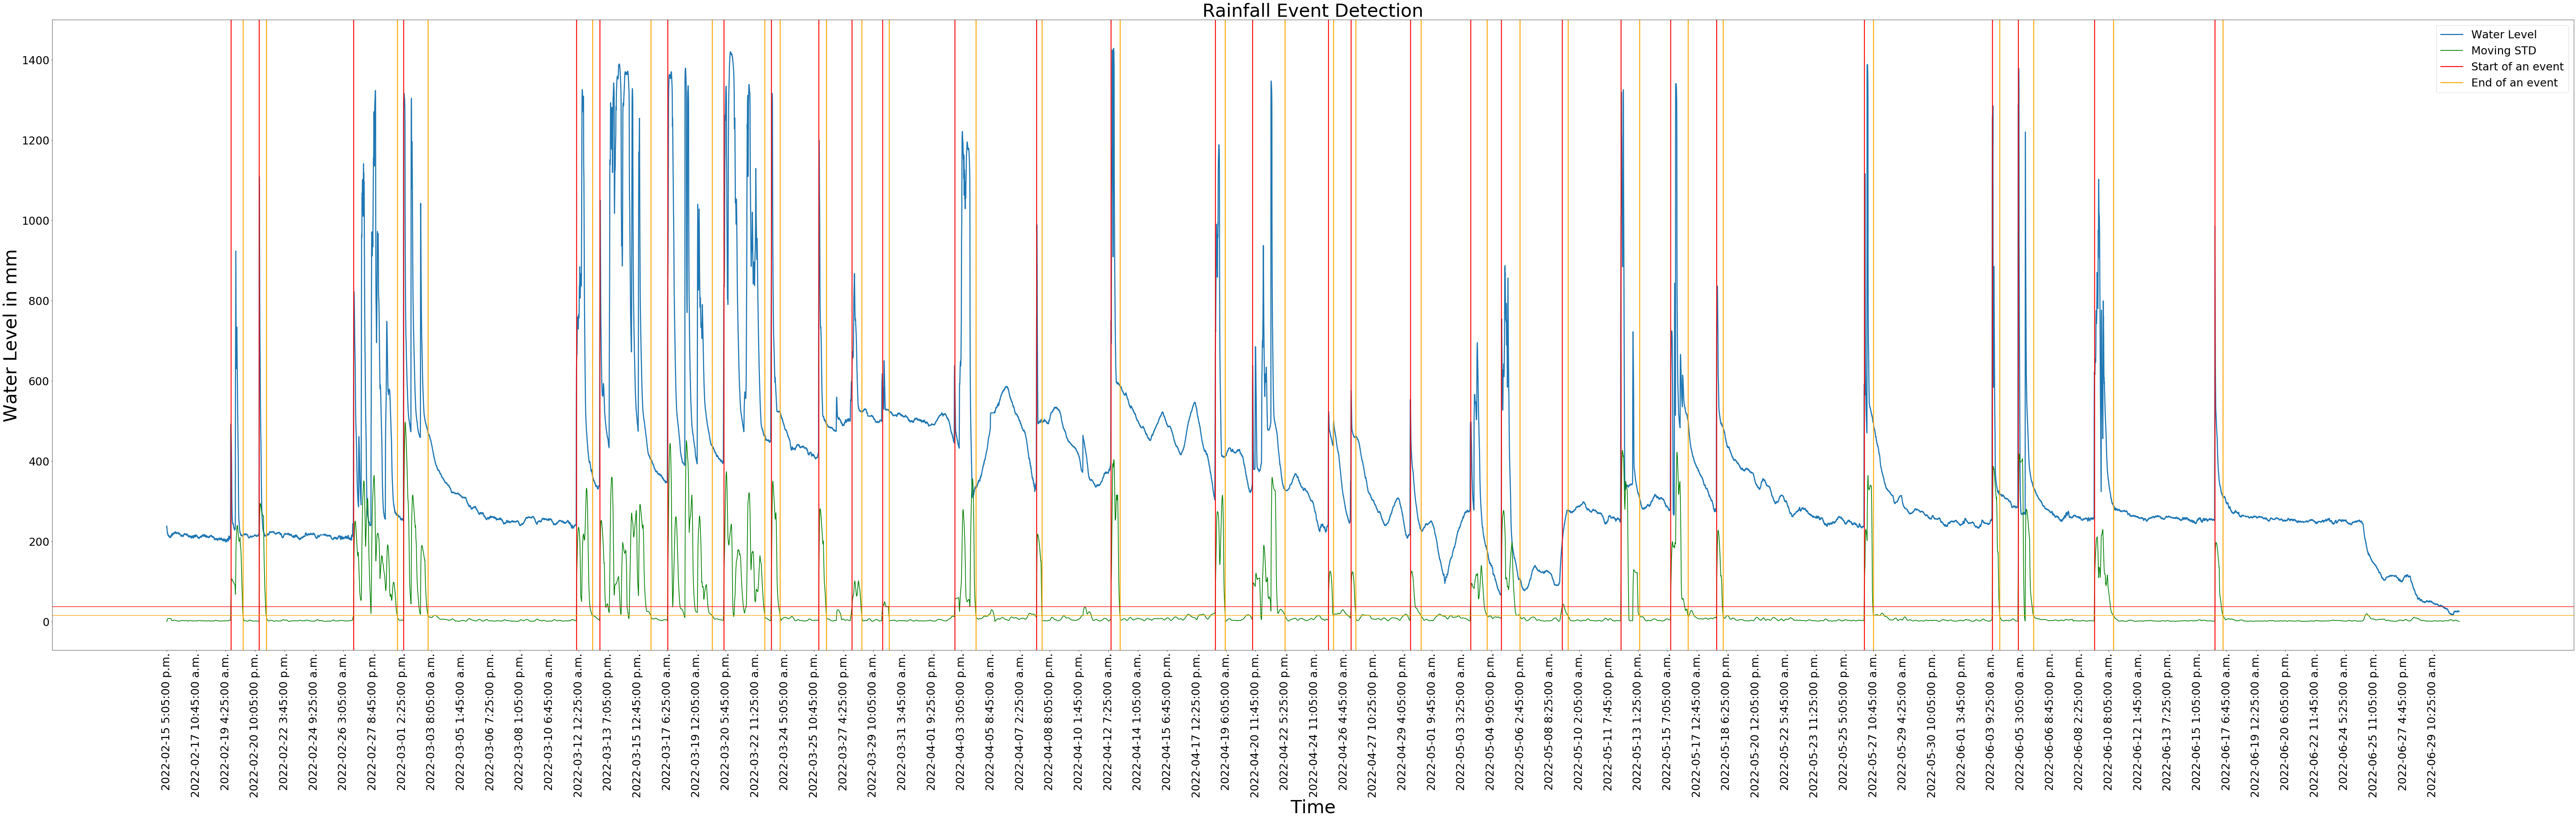

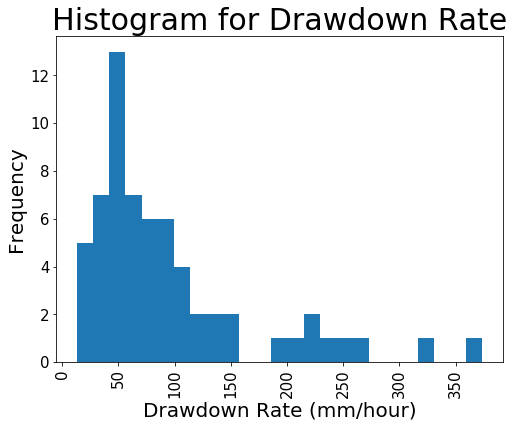

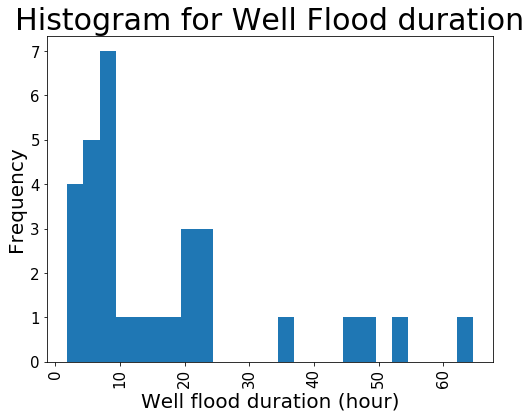

14.894451850536207 37.23612962634052


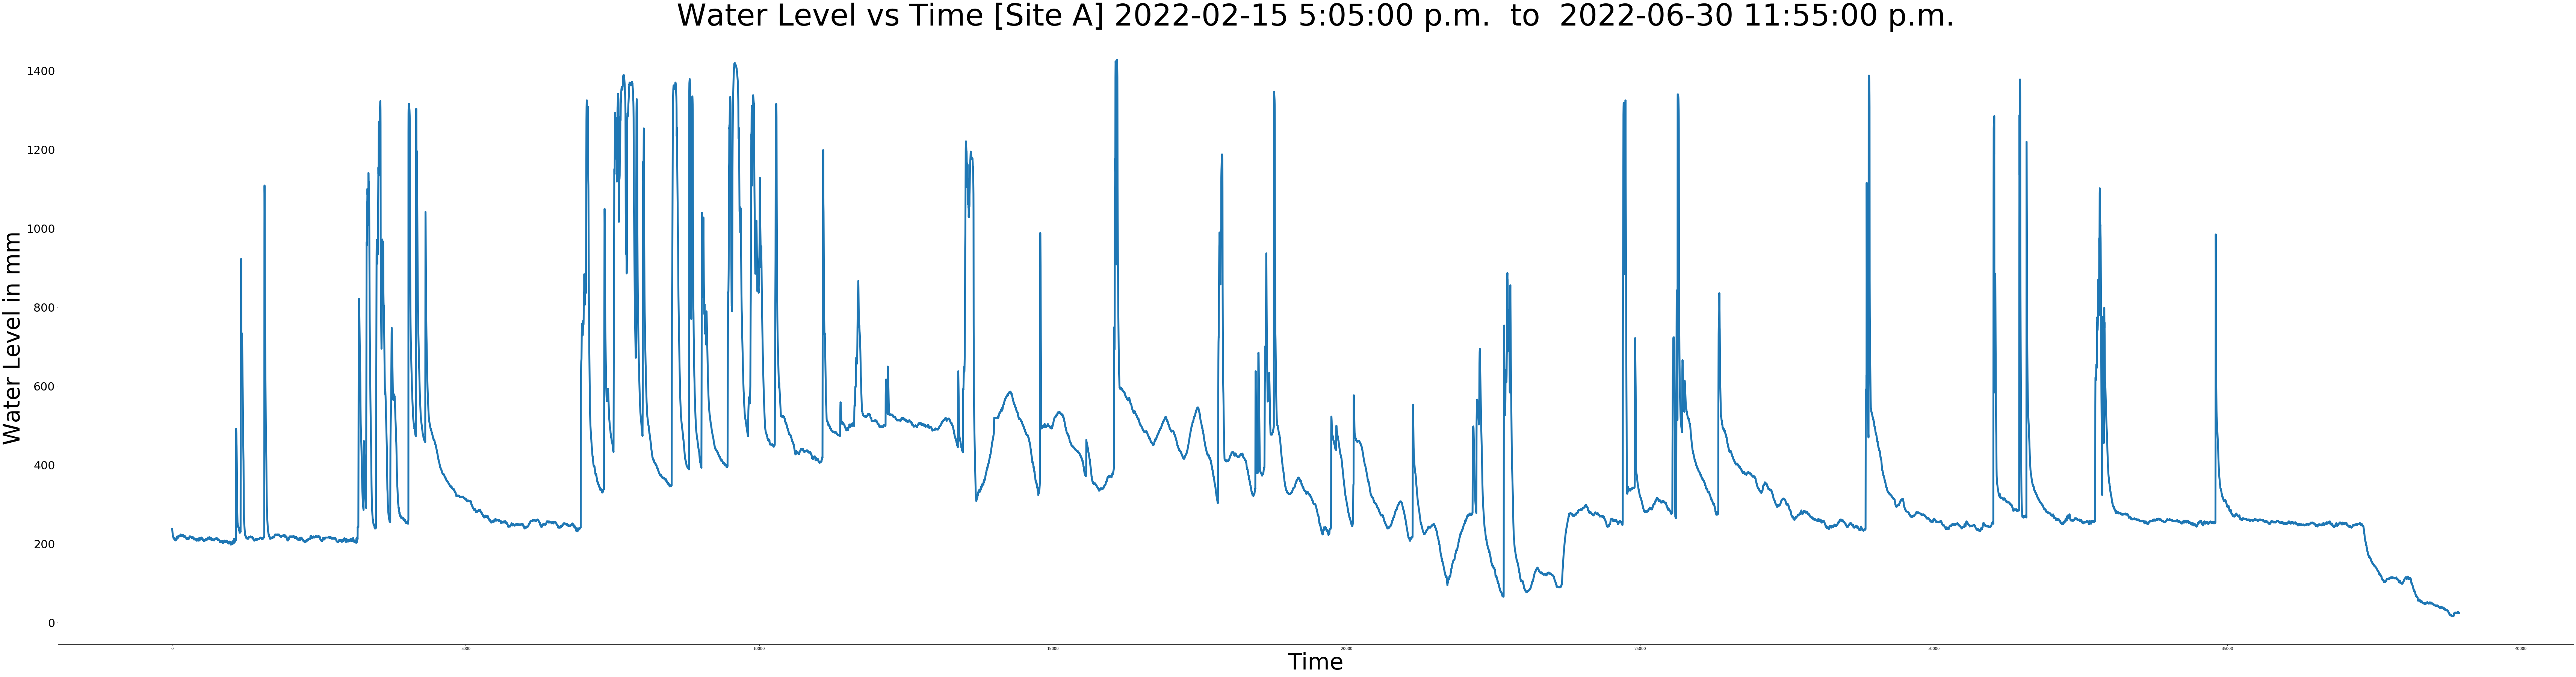

In [1762]:
std_movA=moving_std(sADF,6)
rng3pA=np.max(std_movA)*(3/100)
rng8pA=np.max(std_movA)*(7.5/100)
print(rng3pA,rng8pA)
#np.mean(std_movA)

fig=plt.figure(figsize=(120, 30))
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.set_xticks([i for i in range(0,np.size(water_levelA),500)])
#ax.set_xticklabels([sADF["Timestamp"][i] for i in range(0,np.size(water_levelA),500)])

plt.plot(wl_mmA,linewidth=5,label="Water Level in mm")
#plt.plot(std_movA,linewidth=3,color="green")
plt.xlabel('Time',fontsize=60)
plt.ylabel('Water Level in mm',fontsize=60)
#plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
#plt.legend(loc = 'best',fontsize=30)
plt.title("Water Level vs Time [Site A] "+sADF["Timestamp"][0]+"  to  "+sADF["Timestamp"][sADF.shape[0]-1],fontsize=80)
#plt.title("Water Level",fontsize=50)
plt.show()

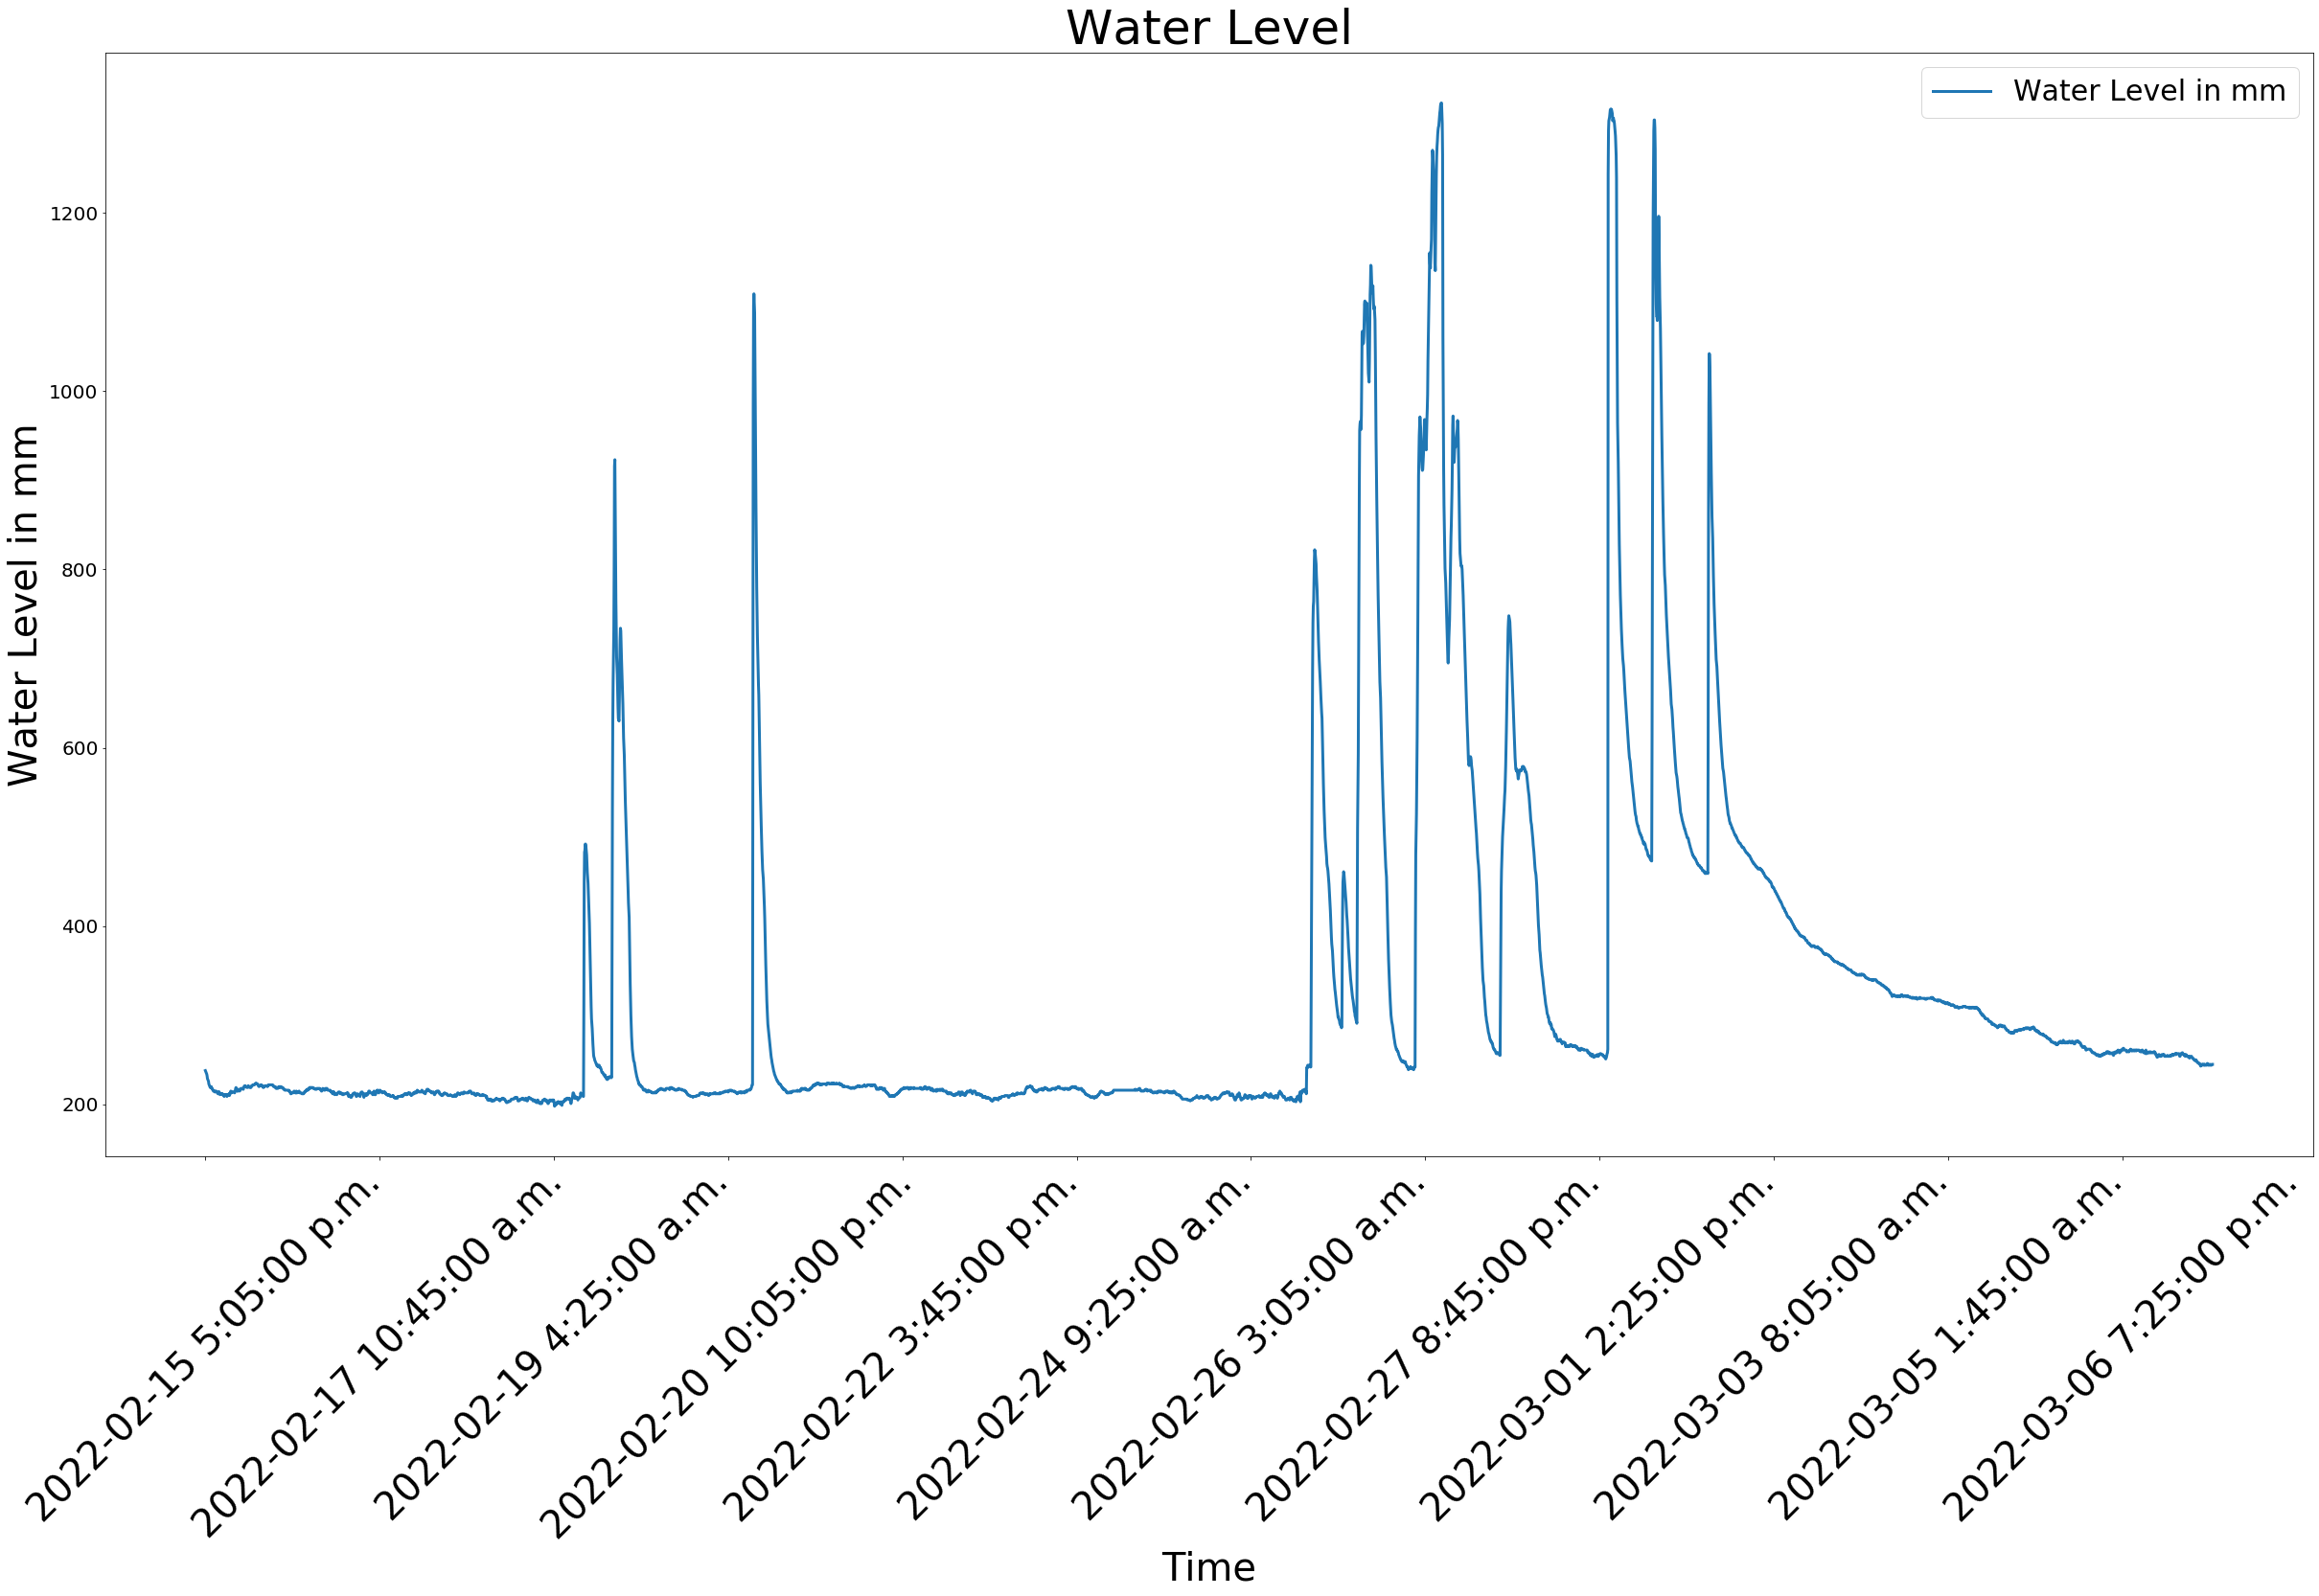

In [1744]:
fig=plt.figure(figsize=(40, 20))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,np.size(water_levelA[:5760]),500)])
ax.set_xticklabels([sADF["Timestamp"][i] for i in range(0,np.size(water_levelA[:5760]),500)])

plt.plot(wl_mmA[:5760],linewidth=3,label="Water Level in mm")
#plt.plot(std_movA,linewidth=3,color="green")
plt.xlabel('Time',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=40,rotation=45)
plt.tick_params(axis='y',labelsize=20)
plt.legend(loc = 'best',fontsize=30)
#plt.title("Water Level between "+sADF["Timestamp"][0]+"   to    "+sADF["Timestamp"][sADF.shape[0]-1],fontsize=50)
plt.title("Water Level",fontsize=50)
plt.show()

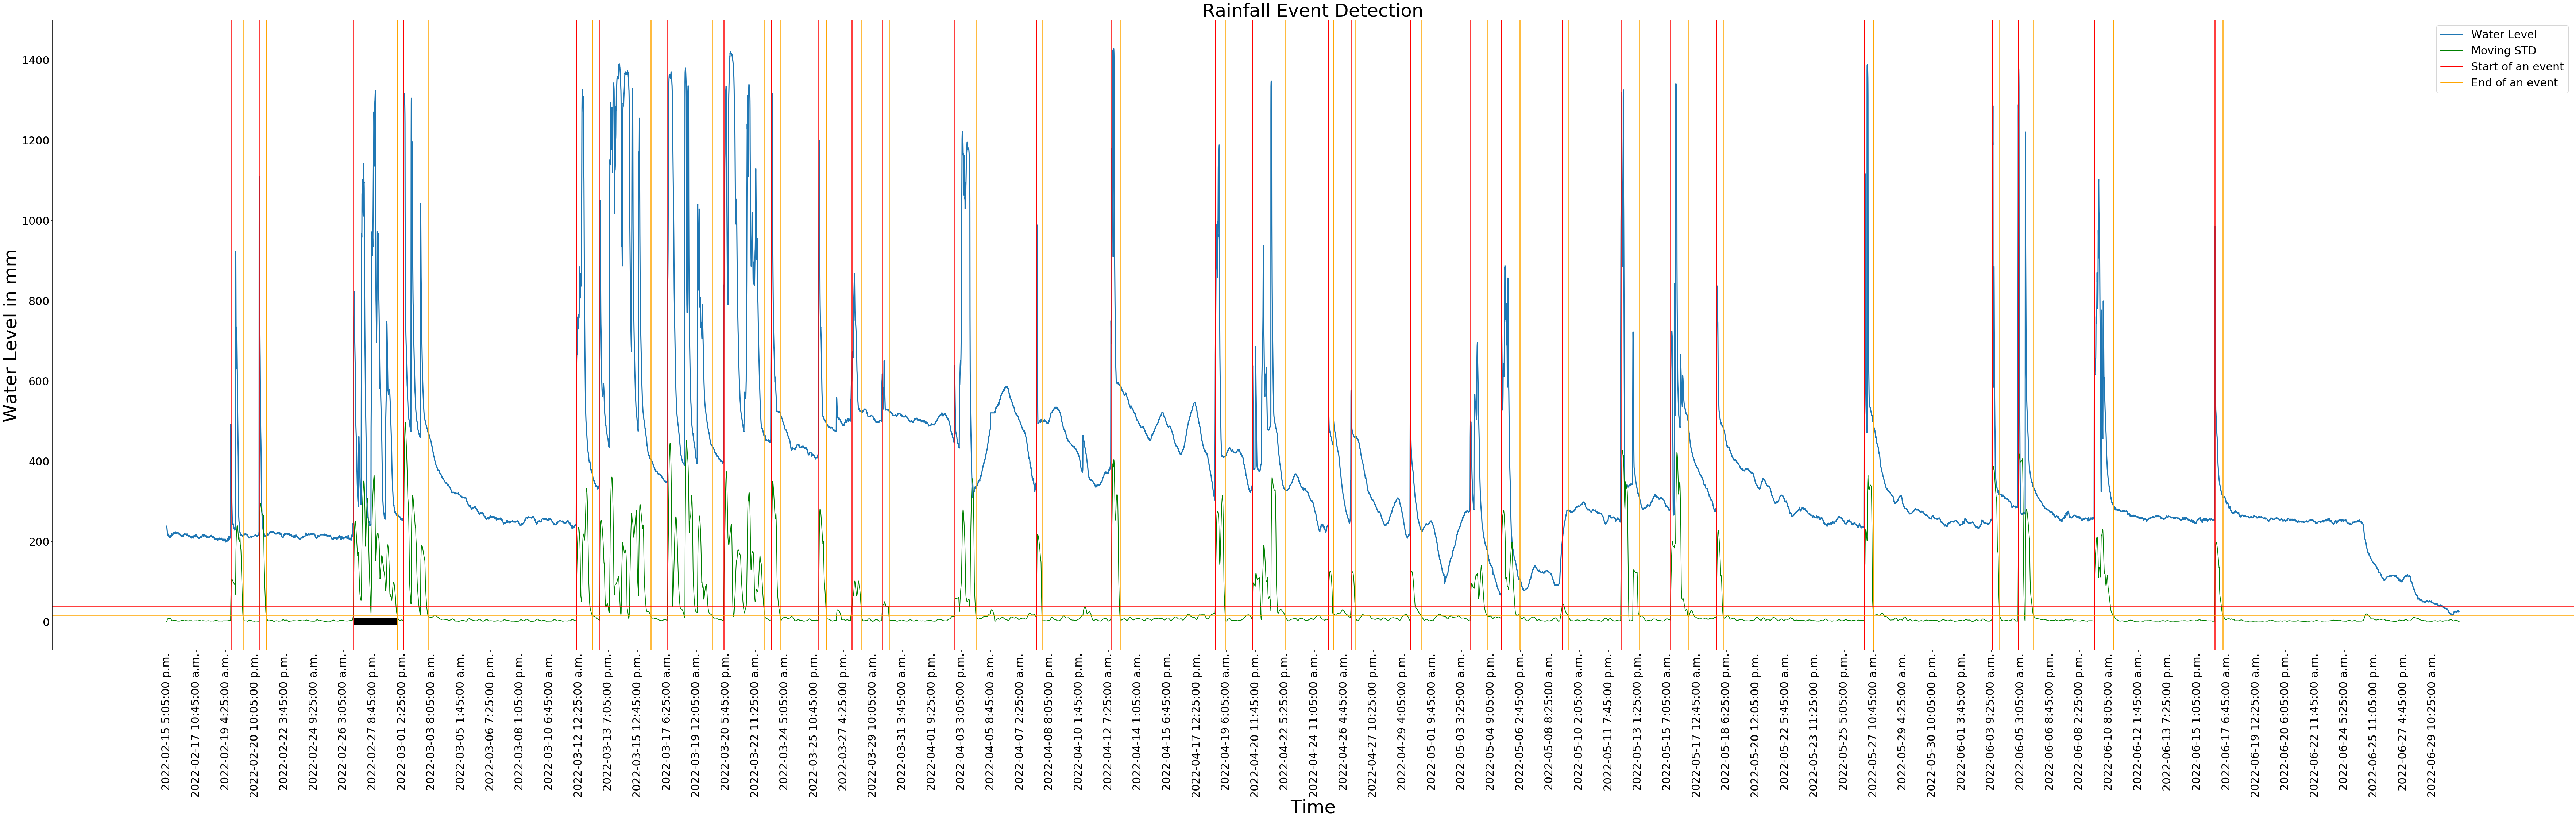

Avergae duration of rainfall event:  23.4758064516129  hours


In [1504]:
# This draw all data set with events being identified
fig=plt.figure(figsize=(120, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,np.size(water_levelA),500)])
ax.set_xticklabels([sADF["Timestamp"][i] for i in range(0,np.size(water_levelA),500)])

wle,=plt.plot(water_levelA,label='Water Level',linewidth=3)
#plt.plot(mean_mov)
mstd,=plt.plot(std_movA,label="Moving STD",linewidth=2,color="green")
for i in start_indexA:
    st=plt.axvline(x=i, linewidth=2.5,color='r',label="Start of an event")
for i in end_indexA:
    en=plt.axvline(x=i,linewidth=2.5, color='orange',label="End of an event")
plt.axhline(y=rng3pA, color='orange', linestyle='-')
plt.axhline(y=rng8pA, color='red', linestyle='-')
plt.hlines(y=0,xmin=3176,xmax=3916, color='black', linewidth=20,linestyle='-')
plt.xlabel('Time',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',handles=[wle,mstd,st,en],fontsize=30)
#plt.title("Water Level between "+sADF["Timestamp"][0]+"   to    "+sADF["Timestamp"][sADF.shape[0]-1],fontsize=50)
plt.title("Rainfall Event Detection",fontsize=50)
plt.show()
print("Avergae duration of rainfall event: ",np.mean(rf_durationA)*(5/60)," hours")

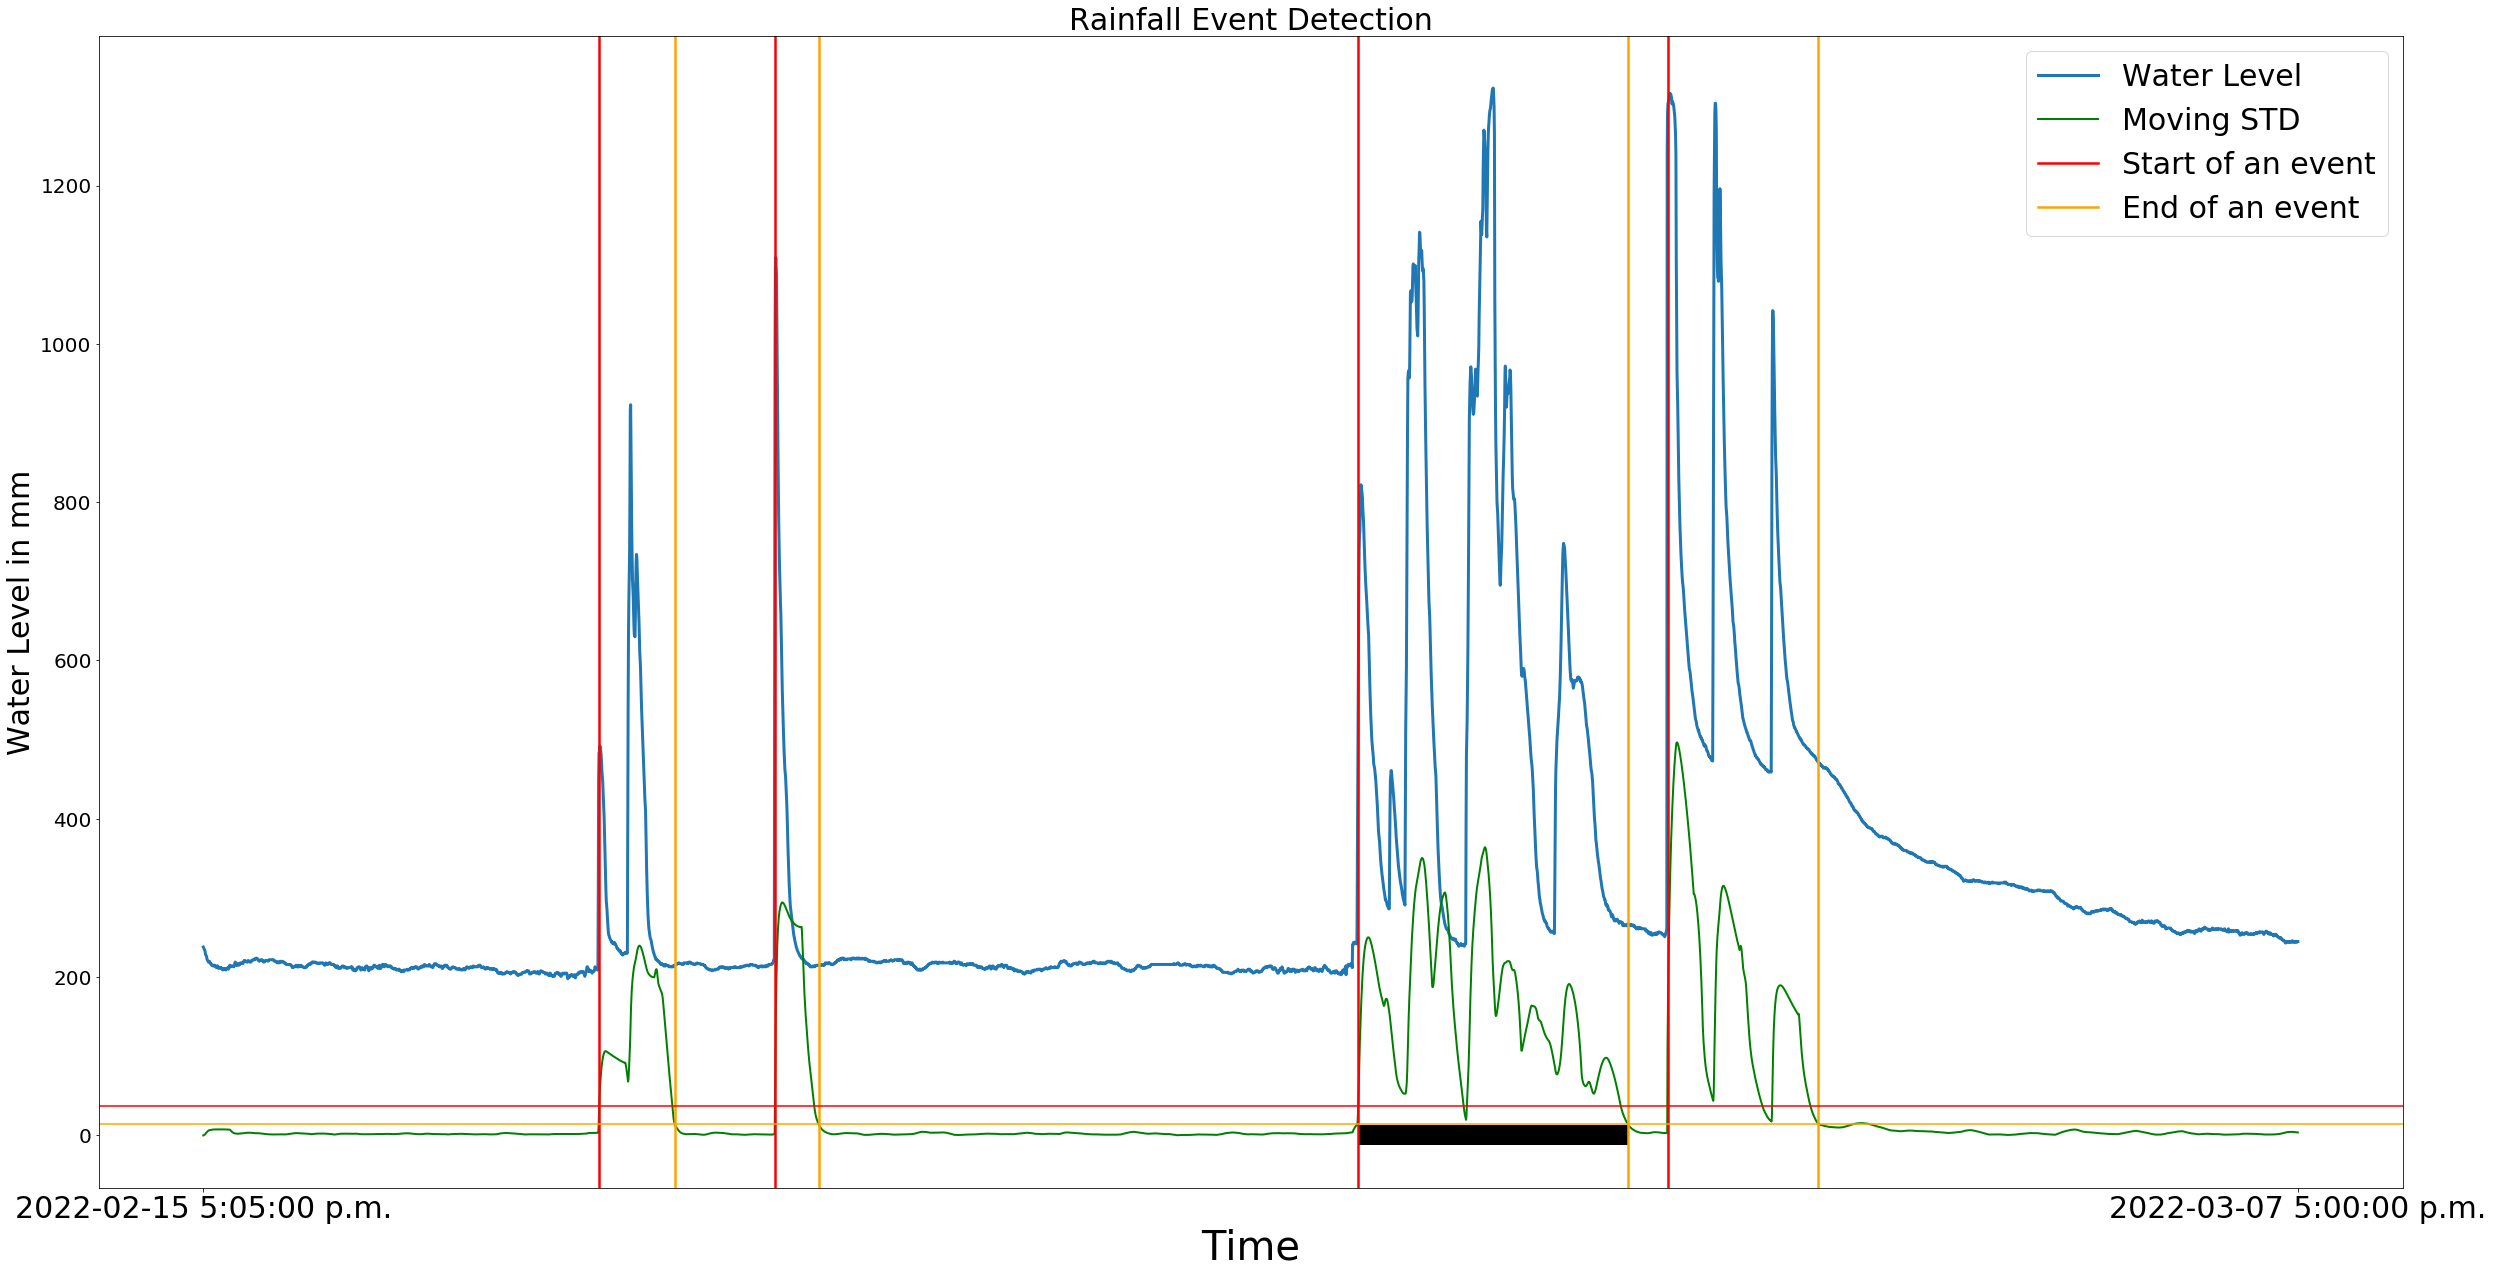

In [1746]:
# This draw (Partial) data set with events being identified
fig=plt.figure(figsize=(40, 20))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,np.size(water_levelA[:5760]),5759)])
ax.set_xticklabels([sADF["Timestamp"][i] for i in range(0,np.size(water_levelA[:5760]),5759)])

wle,=plt.plot(water_levelA[:5760],label='Water Level',linewidth=3)
#plt.plot(mean_mov)
mstd,=plt.plot(std_movA[:5760],label="Moving STD",linewidth=2,color="green")
for i in start_indexA[:4]:
    st=plt.axvline(x=i, linewidth=2.5,color='r',label="Start of an event")
for i in end_indexA[:4]:
    en=plt.axvline(x=i,linewidth=2.5, color='orange',label="End of an event")
plt.axhline(y=rng3pA, color='orange', linestyle='-')
plt.axhline(y=rng8pA, color='red', linestyle='-')
plt.hlines(y=0,xmin=3176,xmax=3916, color='black', linewidth=20,linestyle='-')
plt.xlabel('Time',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=30)
plt.tick_params(axis='x',labelsize=30,rotation=0)
plt.tick_params(axis='y',labelsize=20)
plt.legend(loc = 'best',handles=[wle,mstd,st,en],fontsize=30)
#plt.title("Water Level between "+sADF["Timestamp"][0]+"   to    "+sADF["Timestamp"][5760],fontsize=30)
plt.title("Rainfall Event Detection",fontsize=30)
plt.show()

Text(0.5, 1.0, 'Histogram for Rainfall Event Duration')

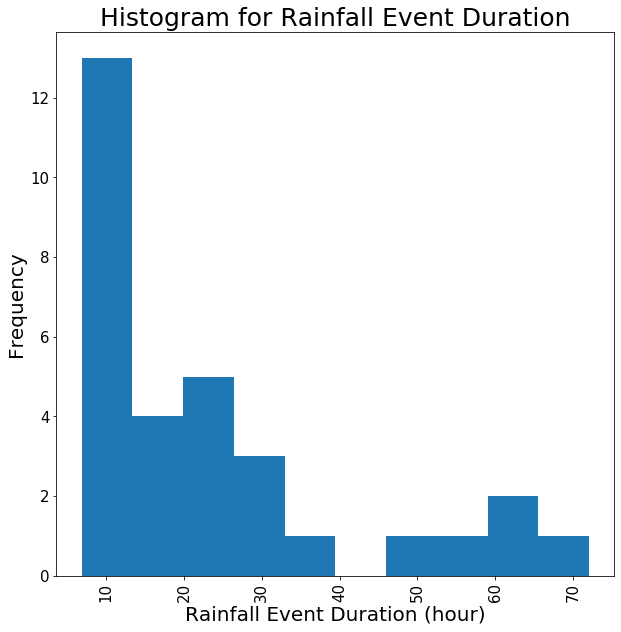

In [1612]:
plt.figure(figsize=(10, 10))
plt.hist(rf_durationA*(5/60))
plt.xlabel('Rainfall Event Duration (hour)',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.tick_params(axis='x',labelsize=15,rotation=90)
plt.tick_params(axis='y',labelsize=15)
plt.title("Histogram for Rainfall Event Duration",fontsize=25)

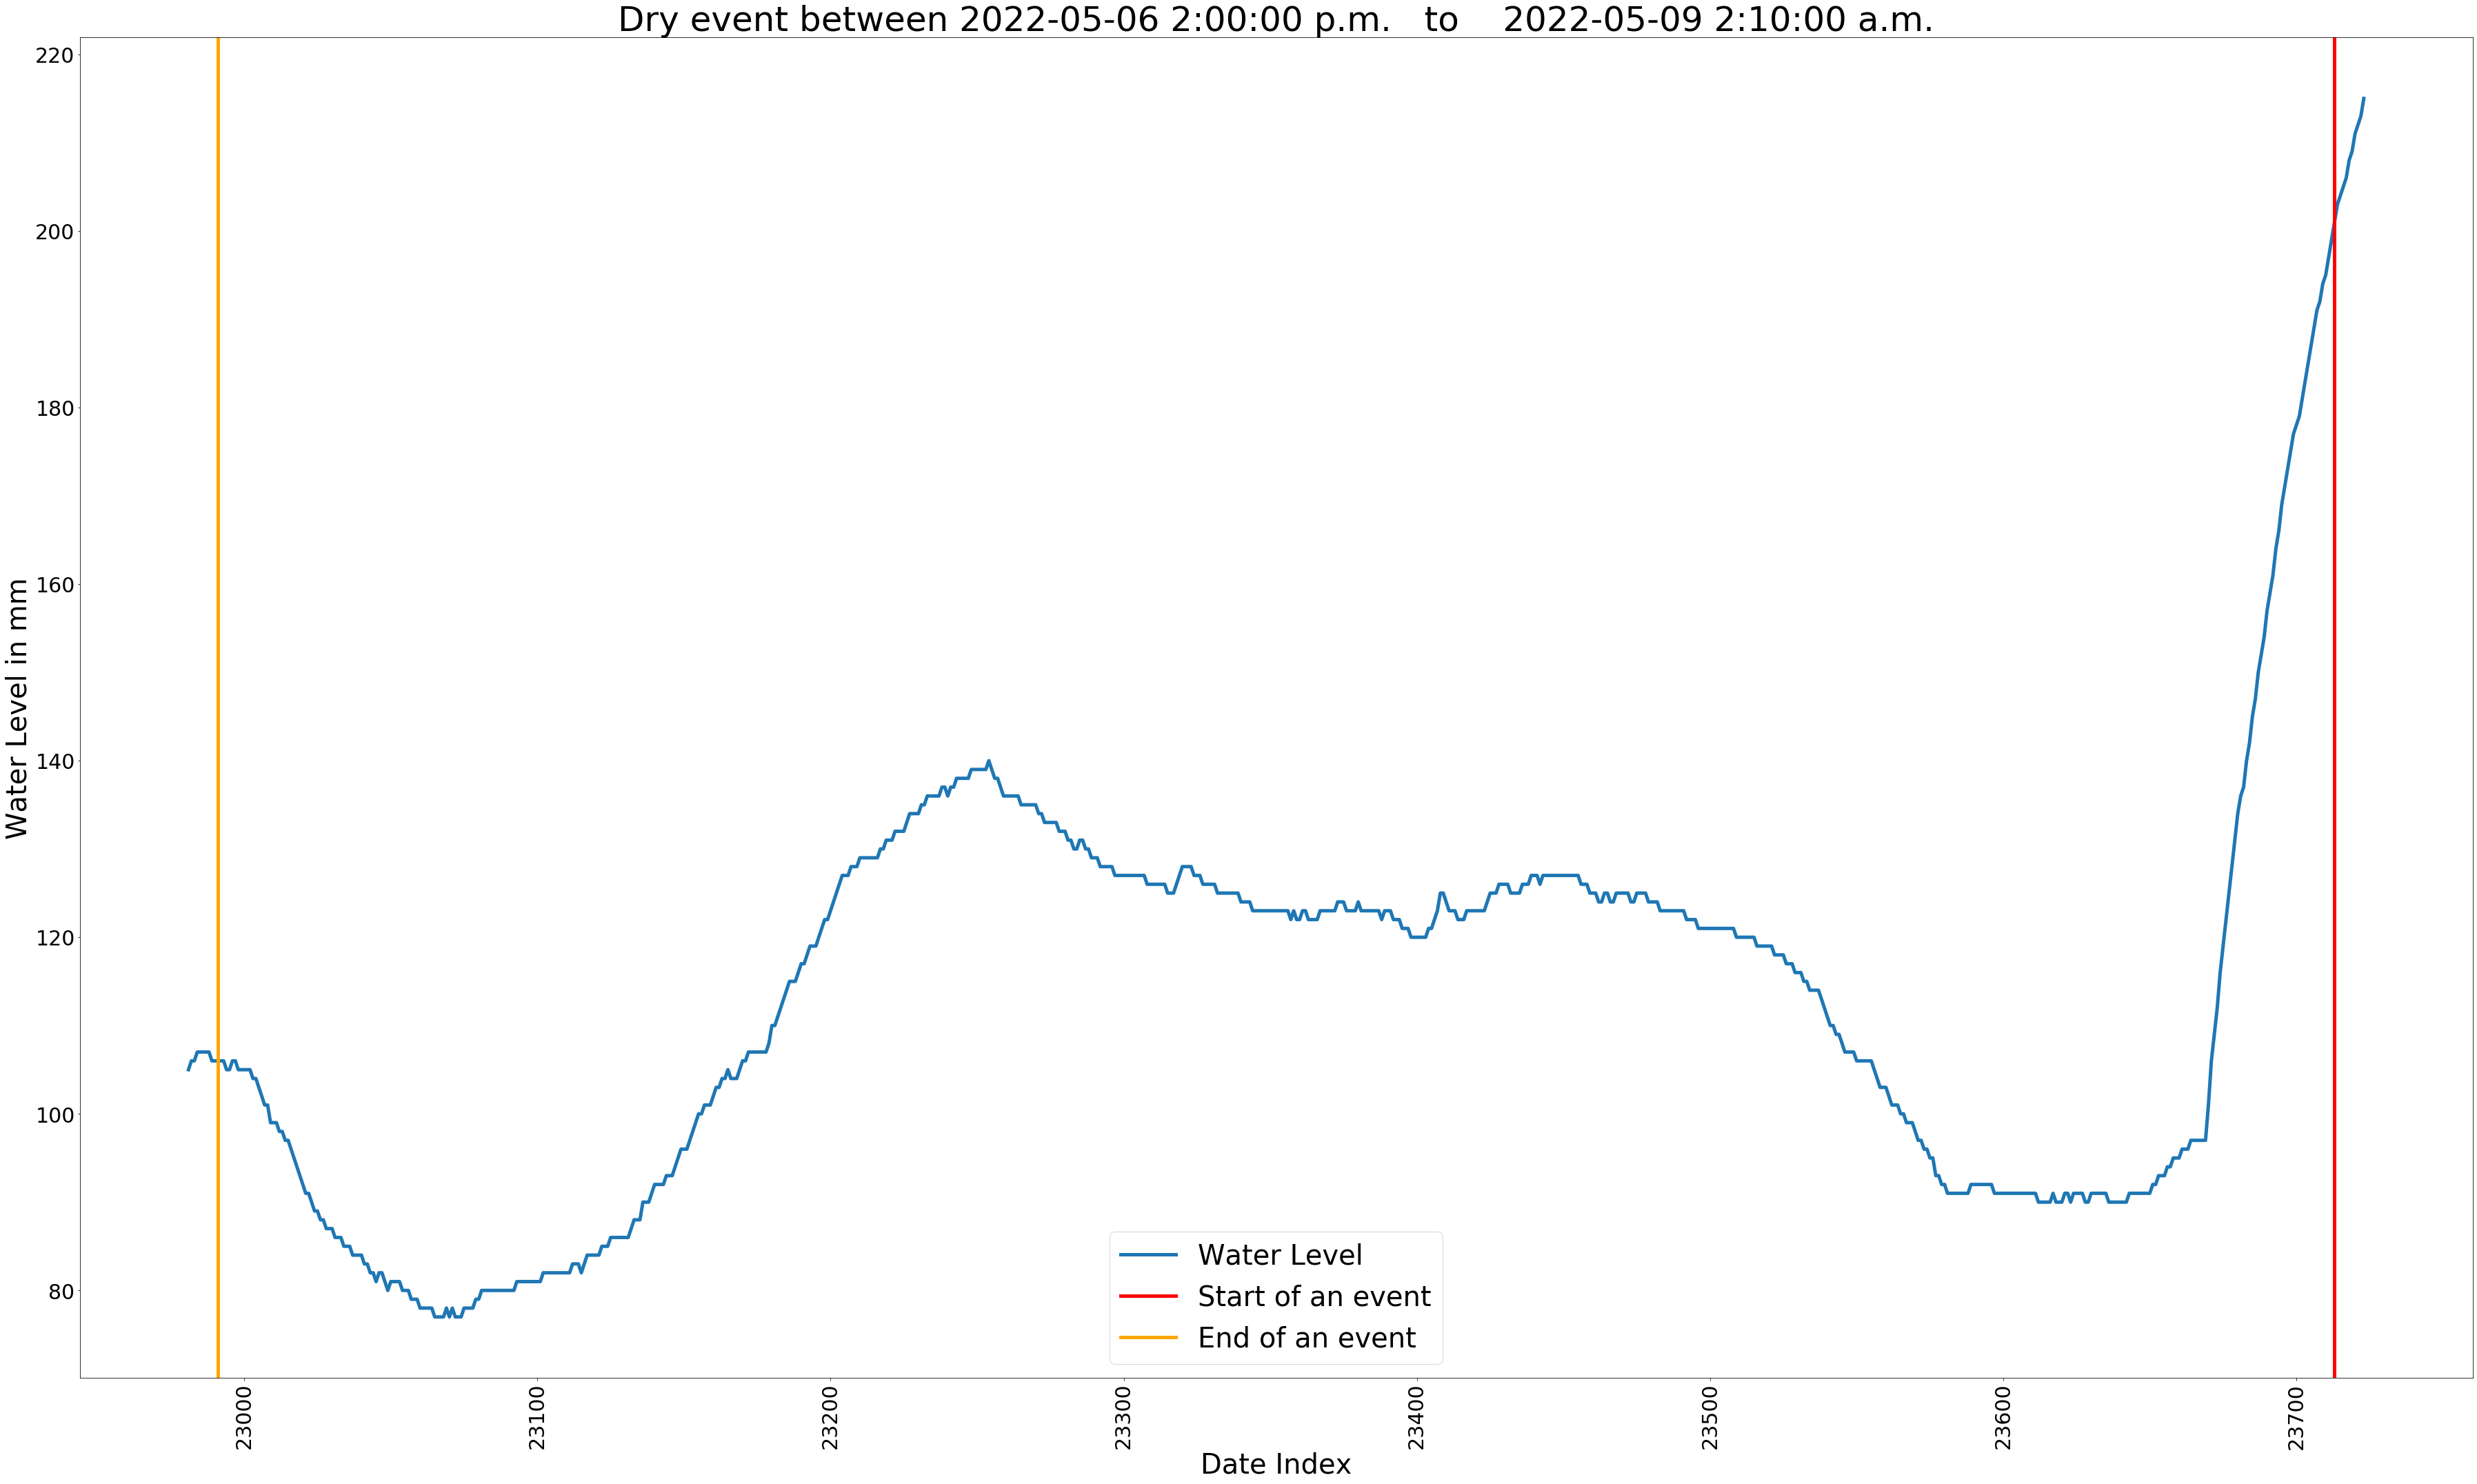

In [1329]:
# Let's look at a particular No !Rainfall event
buffer=10
index=22
X=range(end_indexA[index-1]-buffer,start_indexA[index]+buffer+1)
Y=water_levelA[rf_eventA["Rainfall_end_index"][index-1]-buffer:rf_eventA["Rainfall_start_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexA[index], linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexA[index-1],linewidth=5, color='orange',label="End of an event")
plt.title('No Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.title("Dry event between "+end_timeA[index-1]+"   to    "+start_timeA[index],fontsize=50)
plt.tight_layout()
plt.show()

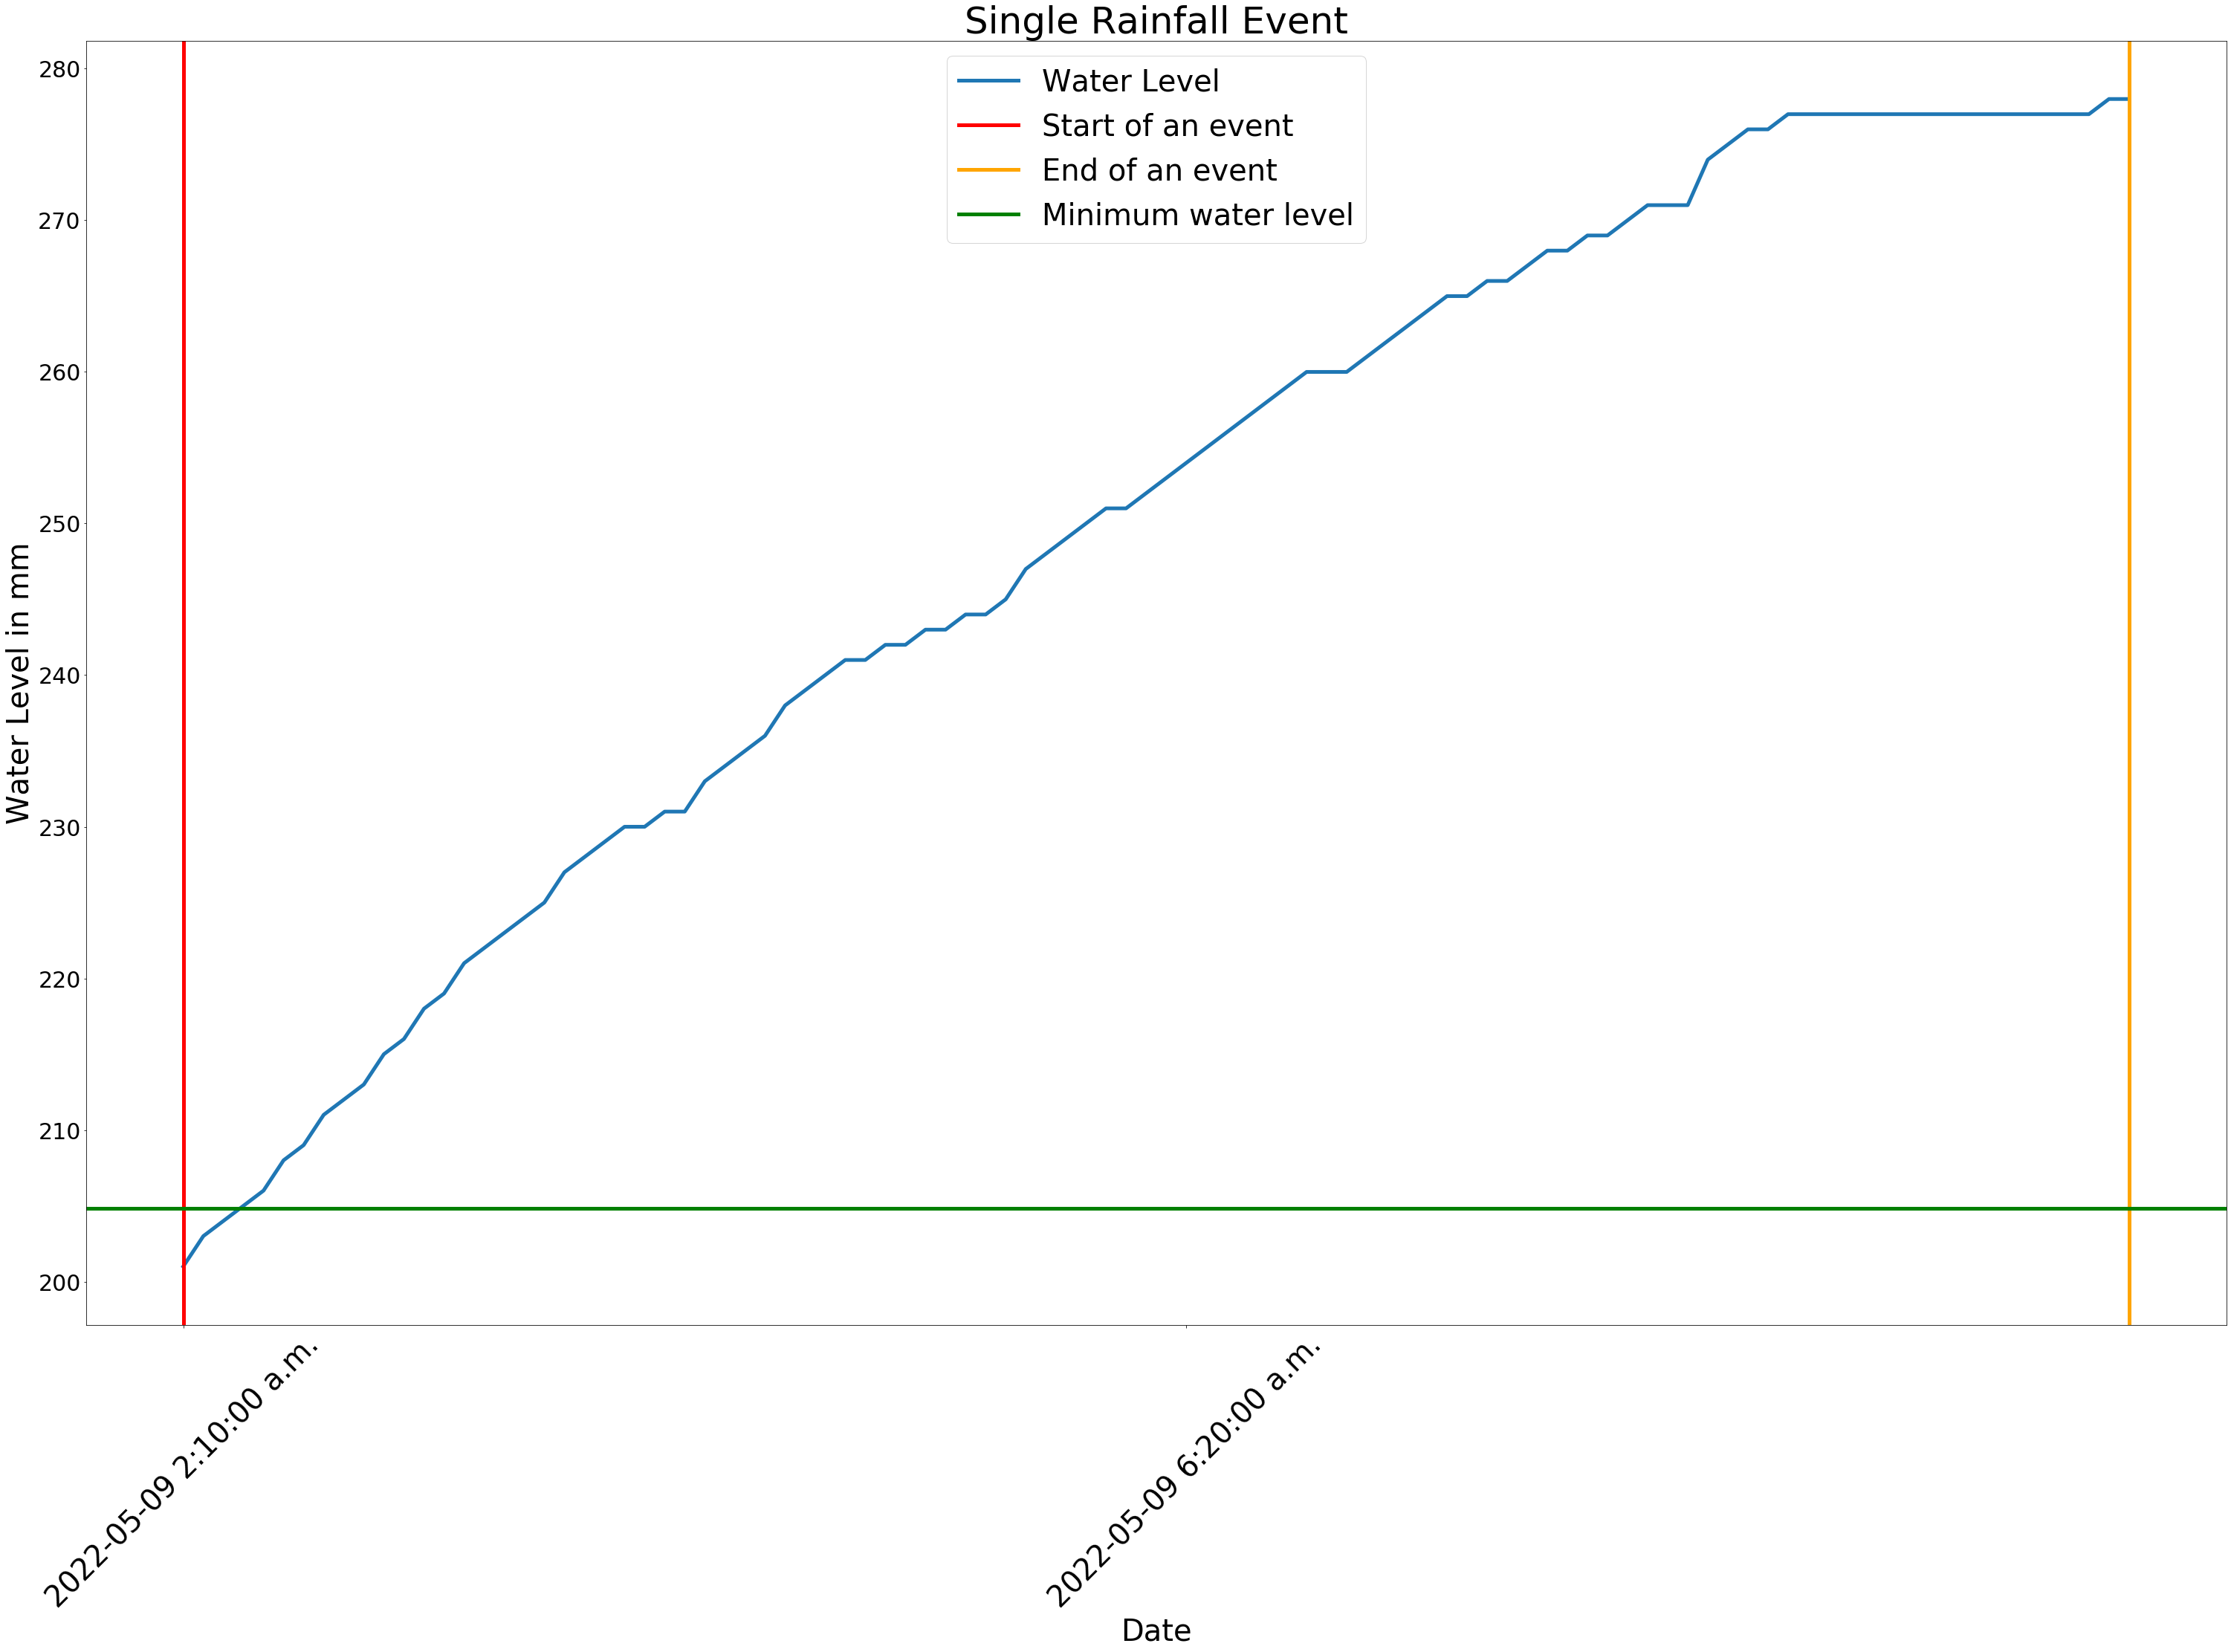

95


In [1836]:
# Let's see a particular !Rainfall event
buffer=0
index=22
#X=Timestamp[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer+1]
X=range(start_indexA[index]-buffer,end_indexA[index]+buffer+1)
Y=water_levelA[start_indexA[index]-buffer:end_indexA[index]+buffer+1]
fig=plt.figure(figsize=(50, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(start_indexA[index],end_indexA[index],50)])
ax.set_xticklabels([sADF["Timestamp"][i] for i in range(start_indexA[index],end_indexA[index],50)])
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexA[index],linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexA[index],linewidth=5, color='orange',label="End of an event")
plt.axhline(y=np.min(Y)+(np.max(Y)-np.min(Y))*0.05,color="green",label="Minimum water level",linewidth=5)
plt.title('Rainfall Event')
plt.xlabel('Date',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=40,rotation=45)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)

#plt.tight_layout()
plt.title("Single Rainfall Event",fontsize=50)
plt.show()

c=0
for i in range(start_indexA[index],end_indexA[index]+1):
    if water_levelA[i]>=np.min(Y)+(np.max(Y)-np.min(Y))*0.05:
        c+=1
print(c)
        

In [1771]:
#This calculates the drawdown rate for all rainfall events
wellflood_duration=[]
drawdown_duration=[]
drawdown_level=[]
drawdown_rate=[]
for i in range(np.size(start_indexA)):
    index=i
    max_mov=moving_max(sADF[start_indexA[index]:end_indexA[index]],0.5)
    std_mov=moving_std(sADF[start_indexA[index]:end_indexA[index]],0.5)
    wl=water_levelA[start_indexA[index]:end_indexA[index]+1]
    
    #Wellflood Duration within an event
    c=0
    for j in wl:
        if j>=np.min(wl)+(np.max(wl)-np.min(wl))*0.05:      # Well flood happens when water level is above 5% of min waterlevel within an event
            c+=1
    wellflood_duration.append(c*(5/60))
    
    # finding peak and bottom (wellflood duration)
    start=[]
    end=[]
    i=1
    while i <np.size(wl)-1:
        if max_mov[i]-wl[i]>0:
            start.append(i-1)
            while max_mov[i]-wl[i]>0:
                i+=1
                if i>=np.size(wl):
                    break
            end.append(i-1)
        i+=1
    # Discards peaks that's have very small amount of drawdown
    i=0
    while i<np.size(start)-1:
        if abs(wl[start[i]]-wl[end[i]])<150:
            if wl[start[i]]<wl[start[i+1]]:
                start.pop(i)
                end.pop(i)
            else:
                start.pop(i+1)
                end.pop(i)
            continue
        else:
            i+=1
    i=0
    while i<np.size(start)-1:  
        if abs(wl[end[i]]-wl[start[i+1]])<150:
            end.pop(i)
            start.pop(i+1)
            continue
        else:
            i+=1
    # Discard peaks which are very close to each other
    i=0
    while i<np.size(start)-1:
        if (start[i+1]-start[i])<25:
            if wl[start[i+1]]>wl[start[i]]:
                start.pop(i)
                end.pop(i)
            else:
                start.pop(i+1)
                end.pop(i)
            continue
        else:
            i+=1   
            
    
    for i in range(np.size(start)):
        dd=((end[i]-start[i])*5)/60        # Measured in hours
        dl=wl[start[i]]-wl[end[i]]    #measured in mm
        dr=dl/dd                      #Measured in mm/hour
        drawdown_duration.append(dd)
        drawdown_level.append(dl)
        drawdown_rate.append(dr)

Text(0.5, 1.0, 'Histogram for Well Flood duration')

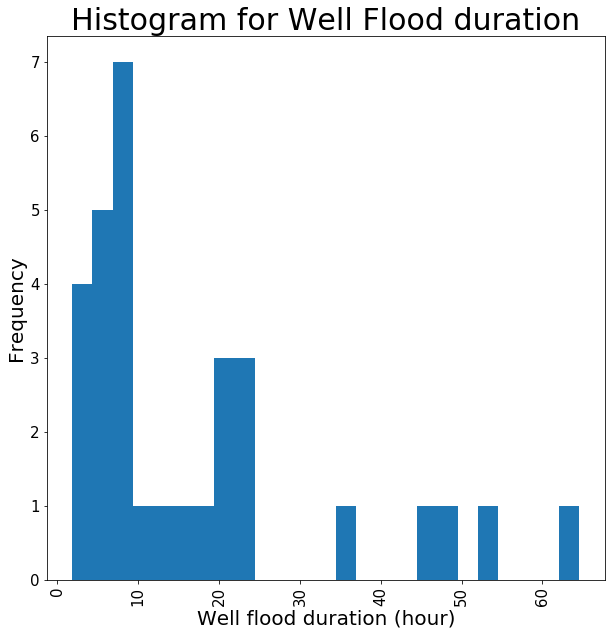

In [1772]:
wellflood_duration
plt.figure(figsize=(10, 10))
plt.hist(wellflood_duration,bins=25)
plt.xlabel("Well flood duration (hour)",fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.tick_params(axis='x',labelsize=15,rotation=90)
plt.tick_params(axis='y',labelsize=15)
plt.title("Histogram for Well Flood duration",fontsize=30)

No of Drawdown:  63  Average Drawdown Rate:  94.77941505200754


Text(0.5, 1.0, 'Histogram for Drawdown Rate')

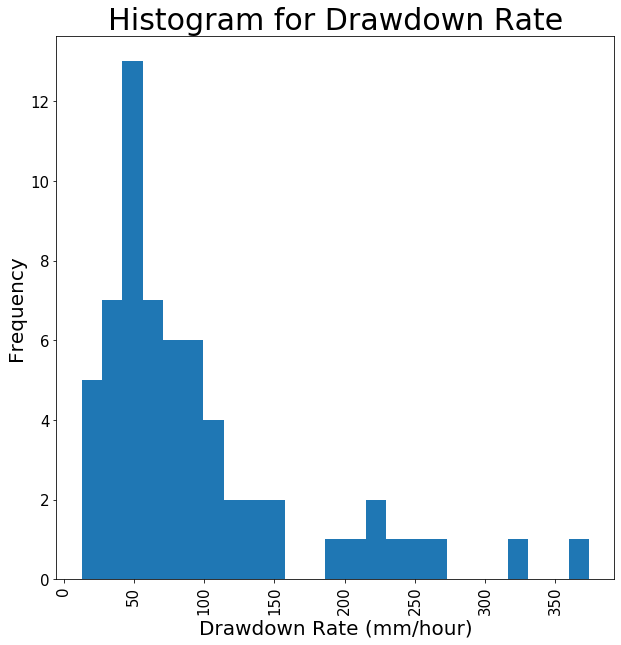

In [1749]:
print("No of Drawdown: ",np.size(drawdown_rate)," Average Drawdown Rate: ",np.mean(drawdown_rate))
plt.figure(figsize=(10, 10))
plt.hist(drawdown_rate,bins=25)
plt.xlabel('Drawdown Rate (mm/hour)',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.tick_params(axis='x',labelsize=15,rotation=90)
plt.tick_params(axis='y',labelsize=15)
plt.title("Histogram for Drawdown Rate",fontsize=30)

Text(0.5, 1.0, 'Histogram for Drawdown Time')

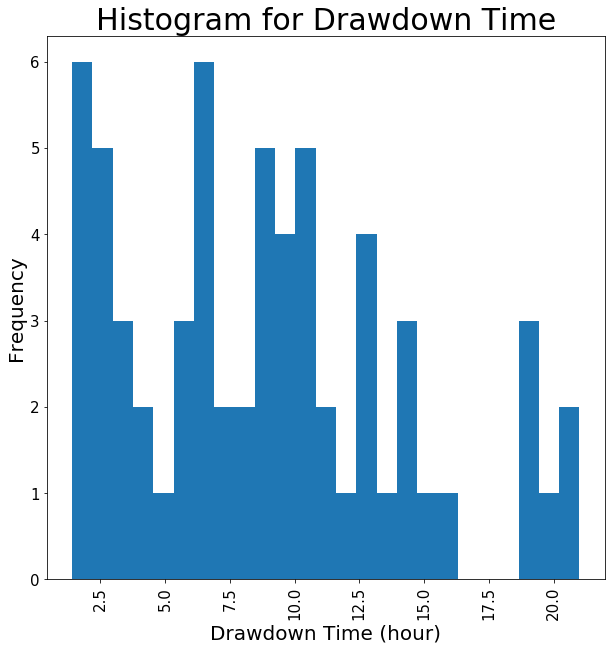

In [1750]:
plt.figure(figsize=(10, 10))
plt.hist(drawdown_duration,bins=25)
plt.xlabel('Drawdown Time (hour)',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.tick_params(axis='x',labelsize=15,rotation=90)
plt.tick_params(axis='y',labelsize=15)
plt.title("Histogram for Drawdown Time",fontsize=30)

In [ ]:
plt.figure(figsize=(10, 10))
plt.hist(drawdown_duration)
plt.xlabel('Drawdown Time (hour)',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.tick_params(axis='x',labelsize=15,rotation=90)
plt.tick_params(axis='y',labelsize=15)
plt.title("Histogram for Drawdown Time",fontsize=30)

741


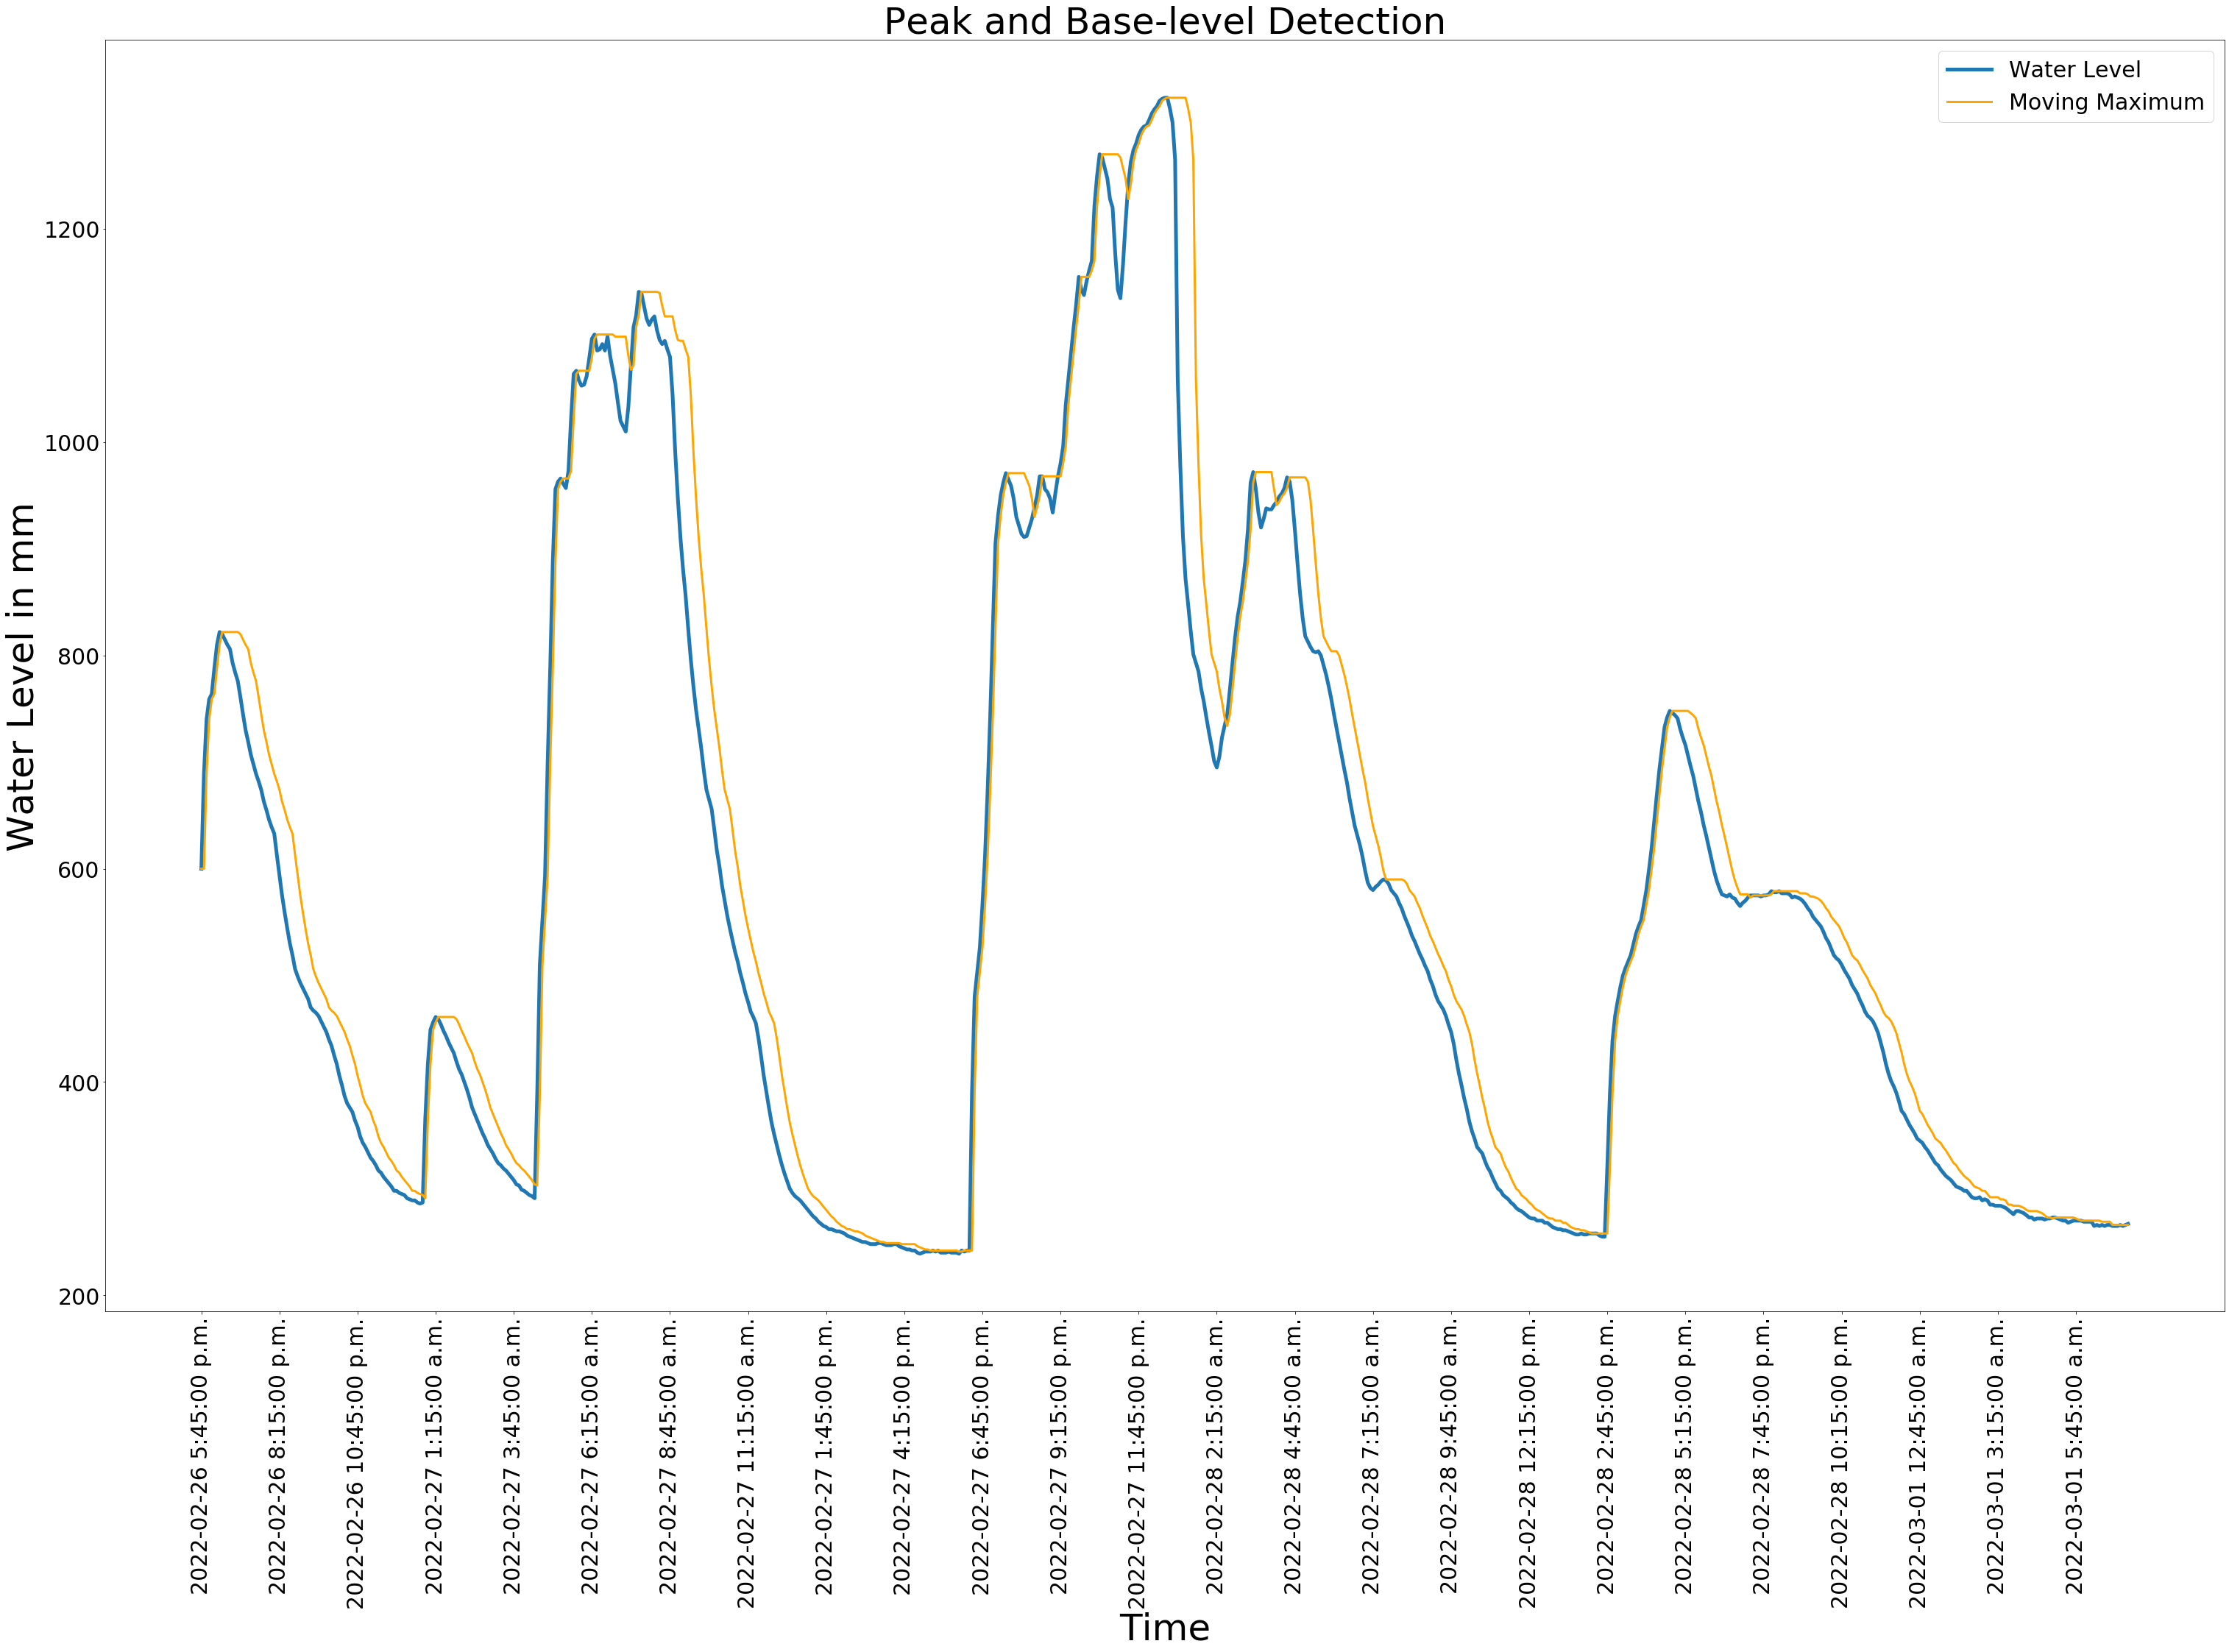

In [1732]:
# This part draws a particular event with moving MAX
buffer=0
index=2
max_mov=moving_max(sADF[start_indexA[index]-buffer:end_indexA[index]+buffer],0.5)
std_mov=moving_std(sADF[start_indexA[index]-buffer:end_indexA[index]+buffer],0.5)
wl=water_levelA[start_indexA[index]-buffer:end_indexA[index]+buffer+1]
print(np.size(wl))
fig=plt.figure(figsize=(50, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,rf_durationA[index],30)])
ax.set_xticklabels([sADF["Timestamp"][i] for i in range(start_indexA[index],end_indexA[index],30)])
plt.plot(wl,linewidth=5,label="Water Level")
#plt.axhline(y=np.min(wl)+(np.max(wl)-np.min(wl))*.01)
plt.xlabel('Time',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.plot(max_mov,linewidth=3,color="orange",label="Moving Maximum")
plt.title("Peak and Base-level Detection",fontsize=50)
plt.legend(loc = 'best',fontsize=30)

In [1733]:
(np.max(wl)-np.min(wl))*.05

54.20000000000002

In [1734]:
# finding peak and bottom (wellflood duration)
np.size(wl)
np.size(std_mov)
start=[]
end=[]
i=1
while i <np.size(wl)-1:
    if max_mov[i]-wl[i]>0:
        start.append(i-1)
        while max_mov[i]-wl[i]>0:
            i+=1
            if i>=np.size(wl):
                break
        end.append(i-1)
    i+=1
np.size(start)
print(start)

[7, 90, 138, 144, 151, 168, 281, 283, 292, 309, 323, 337, 345, 371, 404, 417, 536, 564, 598, 603, 606, 712, 722, 737]


In [1735]:
# Discards peaks that's have very small amount of drawdown
i=0
while i<np.size(start)-1:
    if abs(wl[start[i]]-wl[end[i]])<150:
        if wl[start[i]]<wl[start[i+1]]:
            start.pop(i)
            end.pop(i)
        else:
            start.pop(i+1)
            end.pop(i)
        continue
    else:
        i+=1
print(start)
i=0
while i<np.size(start)-1:  
    if abs(wl[end[i]]-wl[start[i+1]])<150:
        end.pop(i)
        start.pop(i+1)
        continue
    else:
        i+=1
print(start)
# Discard peaks which are very close to each other
i=0
while i<np.size(start)-1:
    if (start[i+1]-start[i])<25:
        if wl[start[i+1]]>wl[start[i]]:
            start.pop(i)
            end.pop(i)
        else:
            start.pop(i+1)
            end.pop(i)
        continue
    else:
        i+=1   
print(start)

[7, 90, 168, 371, 404, 564, 603, 712]
[7, 90, 168, 371, 404, 564]
[7, 90, 168, 371, 404, 564]


In [1736]:
def moving_std_np(wl_mm,period_in_hour):      
    #wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    mov_std=[0]
    mean_mov=[wl_mm[0]]
    for i in range(np.size(wl_mm)):
        periods=int(period_in_hour*(60/5))    
        if i<periods:
            mov_std.append(np.std(wl_mm[:i+1]))
            mean_mov.append(np.mean(wl_mm[:i+1]))
        else:
            mov_std.append(np.std(wl_mm[i-periods:i+1]))
            mean_mov.append(np.mean(wl_mm[i-periods:i+1]))
    return mov_std
mstd=moving_std_np(wl,3)
np.max(mstd)*(3/100)

10.058027092062355

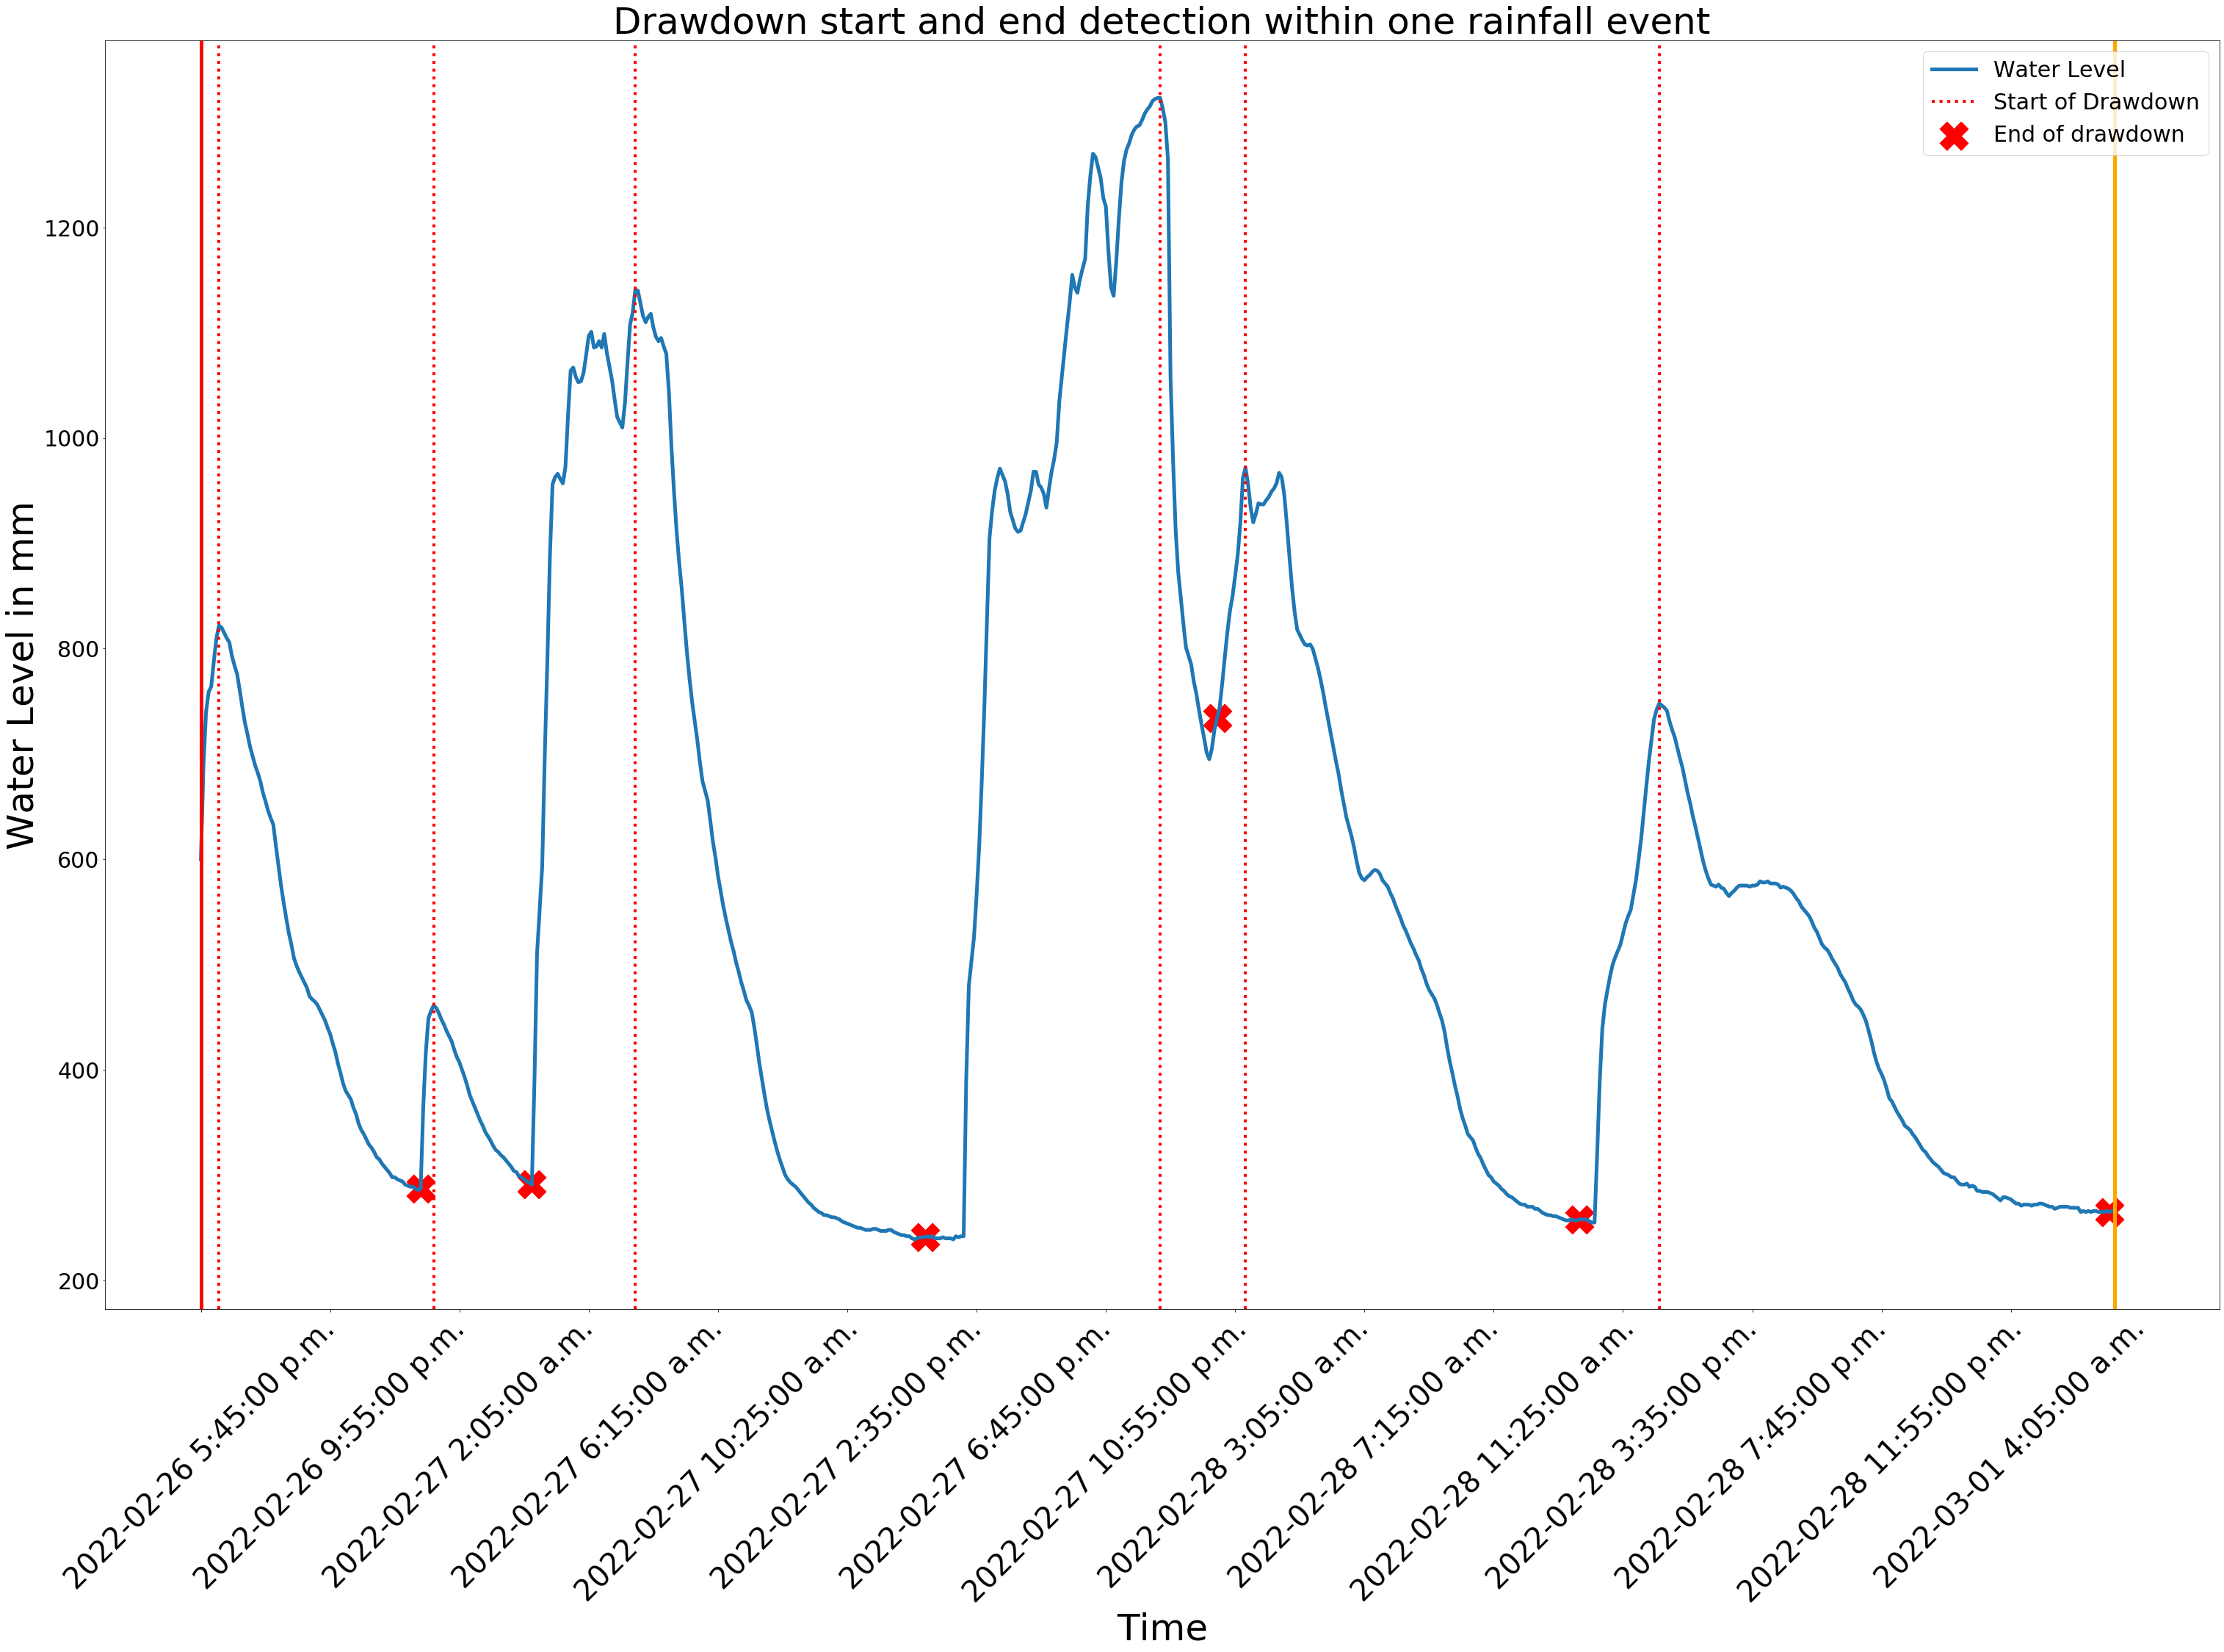

In [1739]:
fig=plt.figure(figsize=(50, 30))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([i for i in range(0,rf_durationA[index],50)])
ax.set_xticklabels([sADF["Timestamp"][i] for i in range(start_indexA[index],end_indexA[index],50)])
wle,=plt.plot(wl,label="Water Level",linewidth=5)
for i in start:
    st=plt.axvline(x=i, linewidth=4,color='r',linestyle="dotted",label="Start of Drawdown")
    #st=plt.scatter(i,wl[i],marker="o",s=1500,color="red",label="Start of drawdown")
for i in end:
    en=plt.scatter(i,wl[i],s=1500,marker="X", color='red',label="End of drawdown")
    #st=plt.axvline(x=i, linewidth=2.5,color='r',linestyle="dashdot",label="Start of an event")
plt.axvline(x=0,linewidth=5,color='r',label="Start of an event")
plt.axvline(x=np.size(wl)-1,linewidth=5, color='orange',label="End of an event")    
#plt.plot(abs(np.diff(wl)))
#plt.plot(mstd)
#plt.axhline(y=14.2)
plt.xlabel('Time',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=40,rotation=45)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',handles=[wle,st,en],fontsize=30)
plt.title("Drawdown start and end detection within one rainfall event",fontsize=50)
plt.show()

In [1572]:
drawdown_duration=[]
drawdown_level=[]
drawdown_rate=[]

In [1573]:
for i in range(np.size(start)):
    dd=((end[i]-start[i])*5)/60        # Measured in hours
    dl=wl[start[i]]-wl[end[i]]    #measured in mm
    dr=dl/dd                      #Measured in mm/hour
    drawdown_duration.append(dd)
    drawdown_level.append(dl)
    drawdown_rate.append(dr)

In [1574]:
drawdown_rate

[82.30769230769232,
 53.68421052631577,
 96.42857142857142,
 321.27272727272737,
 66.4186046511628,
 33.310344827586206]

In [1575]:
drawdown_duration

[6.5, 3.1666666666666665, 9.333333333333334, 1.8333333333333333, 10.75, 14.5]

In [1576]:
drawdown_level

[535.0000000000001, 169.99999999999994, 900.0, 589.0000000000001, 714.0, 483.0]

In [1577]:
np.mean(drawdown_rate)

108.90369183567599

(array([2., 2., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 33.31034483,  62.10658307,  90.90282132, 119.69905956,
        148.49529781, 177.29153605, 206.08777429, 234.88401254,
        263.68025078, 292.47648903, 321.27272727]),
 <a list of 10 Patch objects>)

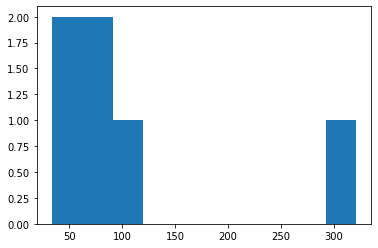

In [1579]:
plt.hist(drawdown_rate)

In [883]:
# This part is for site B

In [876]:
sBDF[" Water Level [m]"].where(sBDF[" Water Level [m]"]>0, 0,inplace=True)

In [1251]:
std_movB=moving_std(sBDF,6)
rng3pB=np.max(std_movB)*(3/100)
rng8pB=np.max(std_movB)*(8/100)

In [1250]:
start_timeB,end_timeB,start_indexB,end_indexB,rf_durationB,water_levelB=IdentifyEvents_3(sBDF,6,6)
rf_eventB=pd.DataFrame({"Rainfall_start_time":start_timeB,"Rainfall_end_time":end_timeB,"Rainfall_start_index":start_indexB,"Rainfall_end_index":end_indexB,"Rainfall_duration":rf_durationB})
rf_eventB

Rainfall_start_time         Rainfall_end_time  Rainfall_start_index  \
0    2022-02-26 7:45:00 p.m.   2022-02-28 2:40:00 p.m.                  3201   
1    2022-03-02 4:25:00 a.m.  2022-03-02 12:40:00 p.m.                  4169   
2    2022-03-06 6:20:00 p.m.  2022-03-07 12:40:00 a.m.                  5488   
3    2022-03-12 4:40:00 a.m.   2022-03-12 2:40:00 p.m.                  7052   
4    2022-03-13 7:50:00 a.m.   2022-03-13 3:05:00 p.m.                  7366   
5   2022-03-13 10:55:00 p.m.   2022-03-15 2:50:00 p.m.                  7547   
6    2022-03-17 9:05:00 a.m.  2022-03-18 12:50:00 a.m.                  8533   
7    2022-03-19 4:30:00 a.m.  2022-03-19 11:55:00 a.m.                  9054   
8    2022-03-20 6:40:00 p.m.   2022-03-21 5:50:00 p.m.                  9512   
9    2022-03-22 1:00:00 a.m.   2022-03-22 5:05:00 p.m.                  9876   
10  2022-03-23 11:45:00 a.m.   2022-03-23 8:10:00 p.m.                 10293   
11   2022-03-26 6:40:00 a.m.   2022-03-26 1:40:00 p.m.                 11096   
12   2022-04-03 4:25:00 p.m.  2022-04-04 11:55:00 a.m.                 13517   
13  2022-04-12 11:05:00 a.m.  2022-04-12 10:20:00 p.m.                 16045   
14   2022-04-18 6:40:00 a.m.   2022-04-19 5:40:00 a.m.                 17720   
15  2022-04-20 11:55:00 p.m.   2022-04-21 8:40:00 p.m.                 18503   
16   2022-04-22 6:10:00 p.m.  2022-04-23 12:15:00 a.m.                 19010   
17   2022-04-25 2:05:00 p.m.   2022-04-25 9:05:00 p.m.                 19825   
18  2022-04-30 12:10:00 p.m.   2022-04-30 5:40:00 p.m.                 21242   
19  2022-05-05 12:20:00 p.m.   2022-05-06 2:10:00 a.m.                 22684   
20   2022-05-12 1:35:00 p.m.  2022-05-13 10:10:00 a.m.                 24715   
21   2022-05-15 2:15:00 p.m.   2022-05-16 1:10:00 p.m.                 25587   
22   2022-05-18 5:50:00 a.m.   2022-05-18 1:30:00 p.m.                 26350   
23  2022-05-26 10:55:00 p.m.  2022-05-27 10:45:00 a.m.                 28859   
24  2022-06-03 11:05:00 a.m.   2022-06-04 1:35:00 a.m.                 31021   
25  2022-06-04 11:50:00 p.m.   2022-06-05 9:45:00 a.m.                 31462   
26   2022-06-09 3:20:00 p.m.   2022-06-10 5:05:00 a.m.                 32800   

    Rainfall_end_index  Rainfall_duration  
0                 3716                515  
1                 4268                 99  
2                 5564                 76  
3                 7172                120  
4                 7453                 87  
5                 8026                479  
6                 8722                189  
7                 9143                 89  
8                 9790                278  
9                10069                193  
10               10394                101  
11               11180                 84  
12               13751                234  
13               16180                135  
14               17996                276  
15               18752                249  
16               19083                 73  
17               19909                 84  
18               21308                 66  
19               22850                166  
20               24962                247  
21               25862                275  
22               26442                 92  
23               29001                142  
24               31195                174  
25               31581                119  
26               32965                165

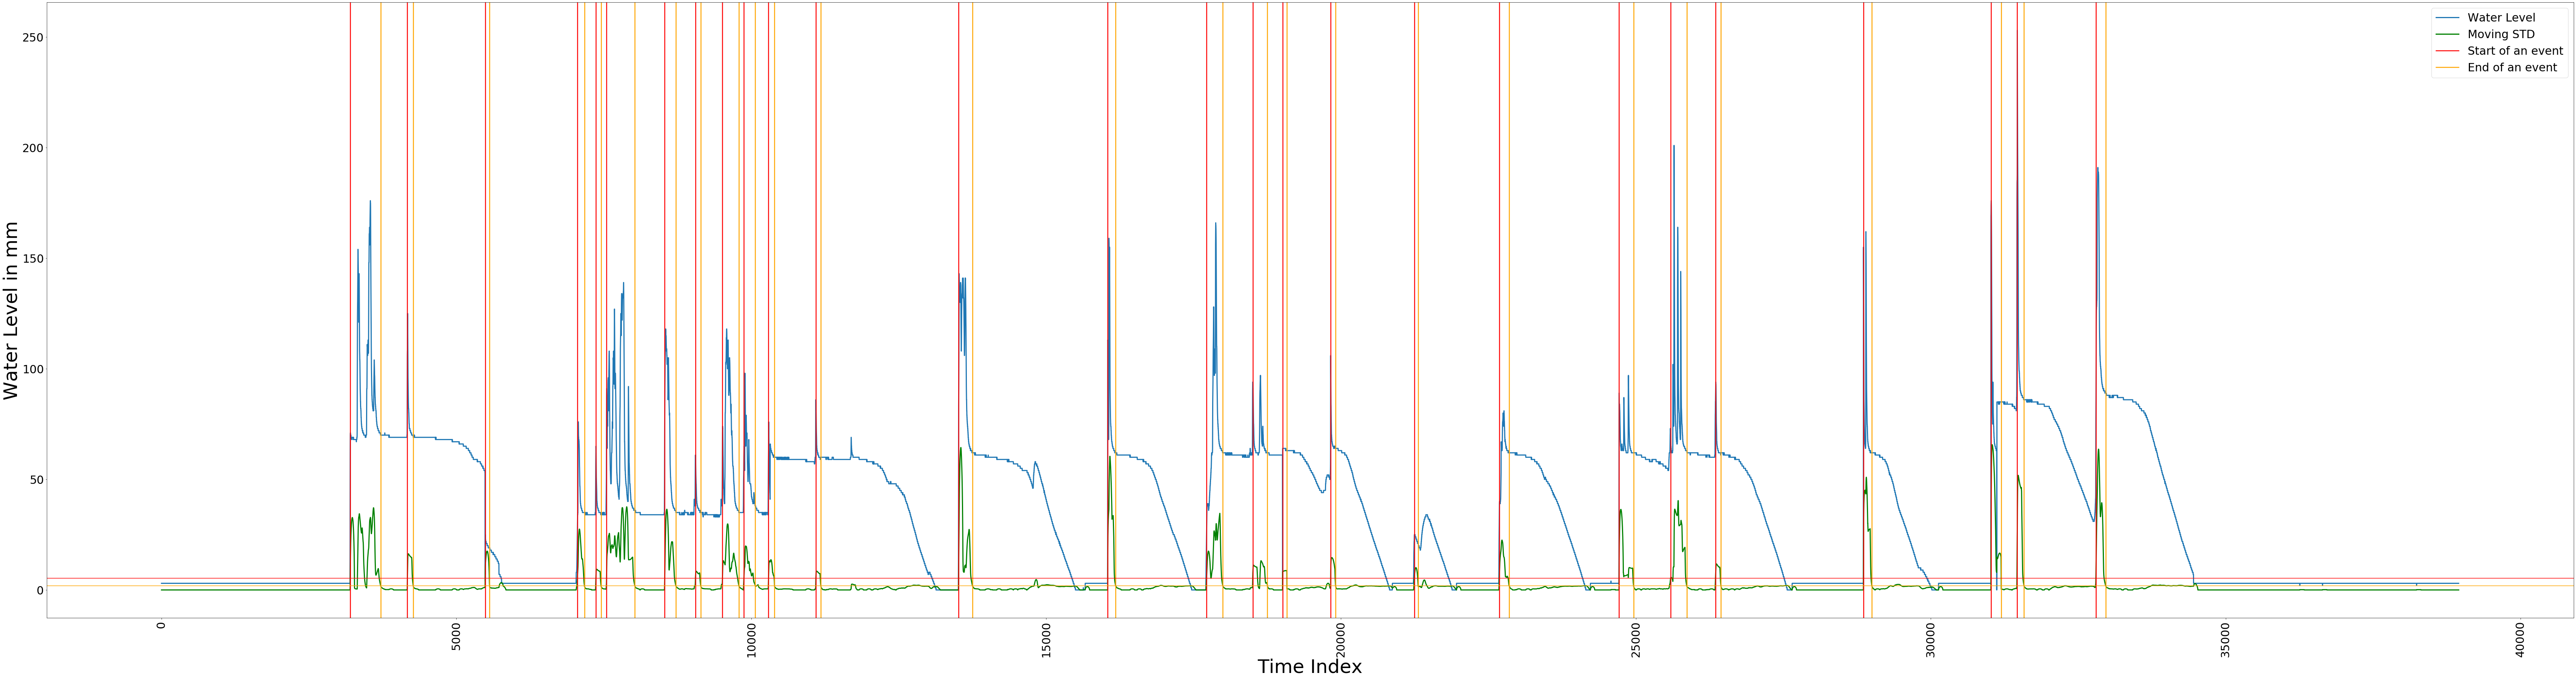

In [1252]:
plt.figure(figsize=(120, 30))
wle,=plt.plot(water_levelB,label='Water Level',linewidth=3)
mstd,=plt.plot(std_movB,label="Moving STD",linewidth=3,color="green")
for i in start_indexB:
    st=plt.axvline(x=i, linewidth=2.5,color='r',label="Start of an event")
for i in end_indexB:
    en=plt.axvline(x=i,linewidth=2.5, color='orange',label="End of an event")
plt.axhline(y=rng3pB, color='orange', linestyle='-')
plt.axhline(y=rng8pB, color='red', linestyle='-')
plt.xlabel('Time Index',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',handles=[wle,mstd,st,en],fontsize=30)
plt.show()

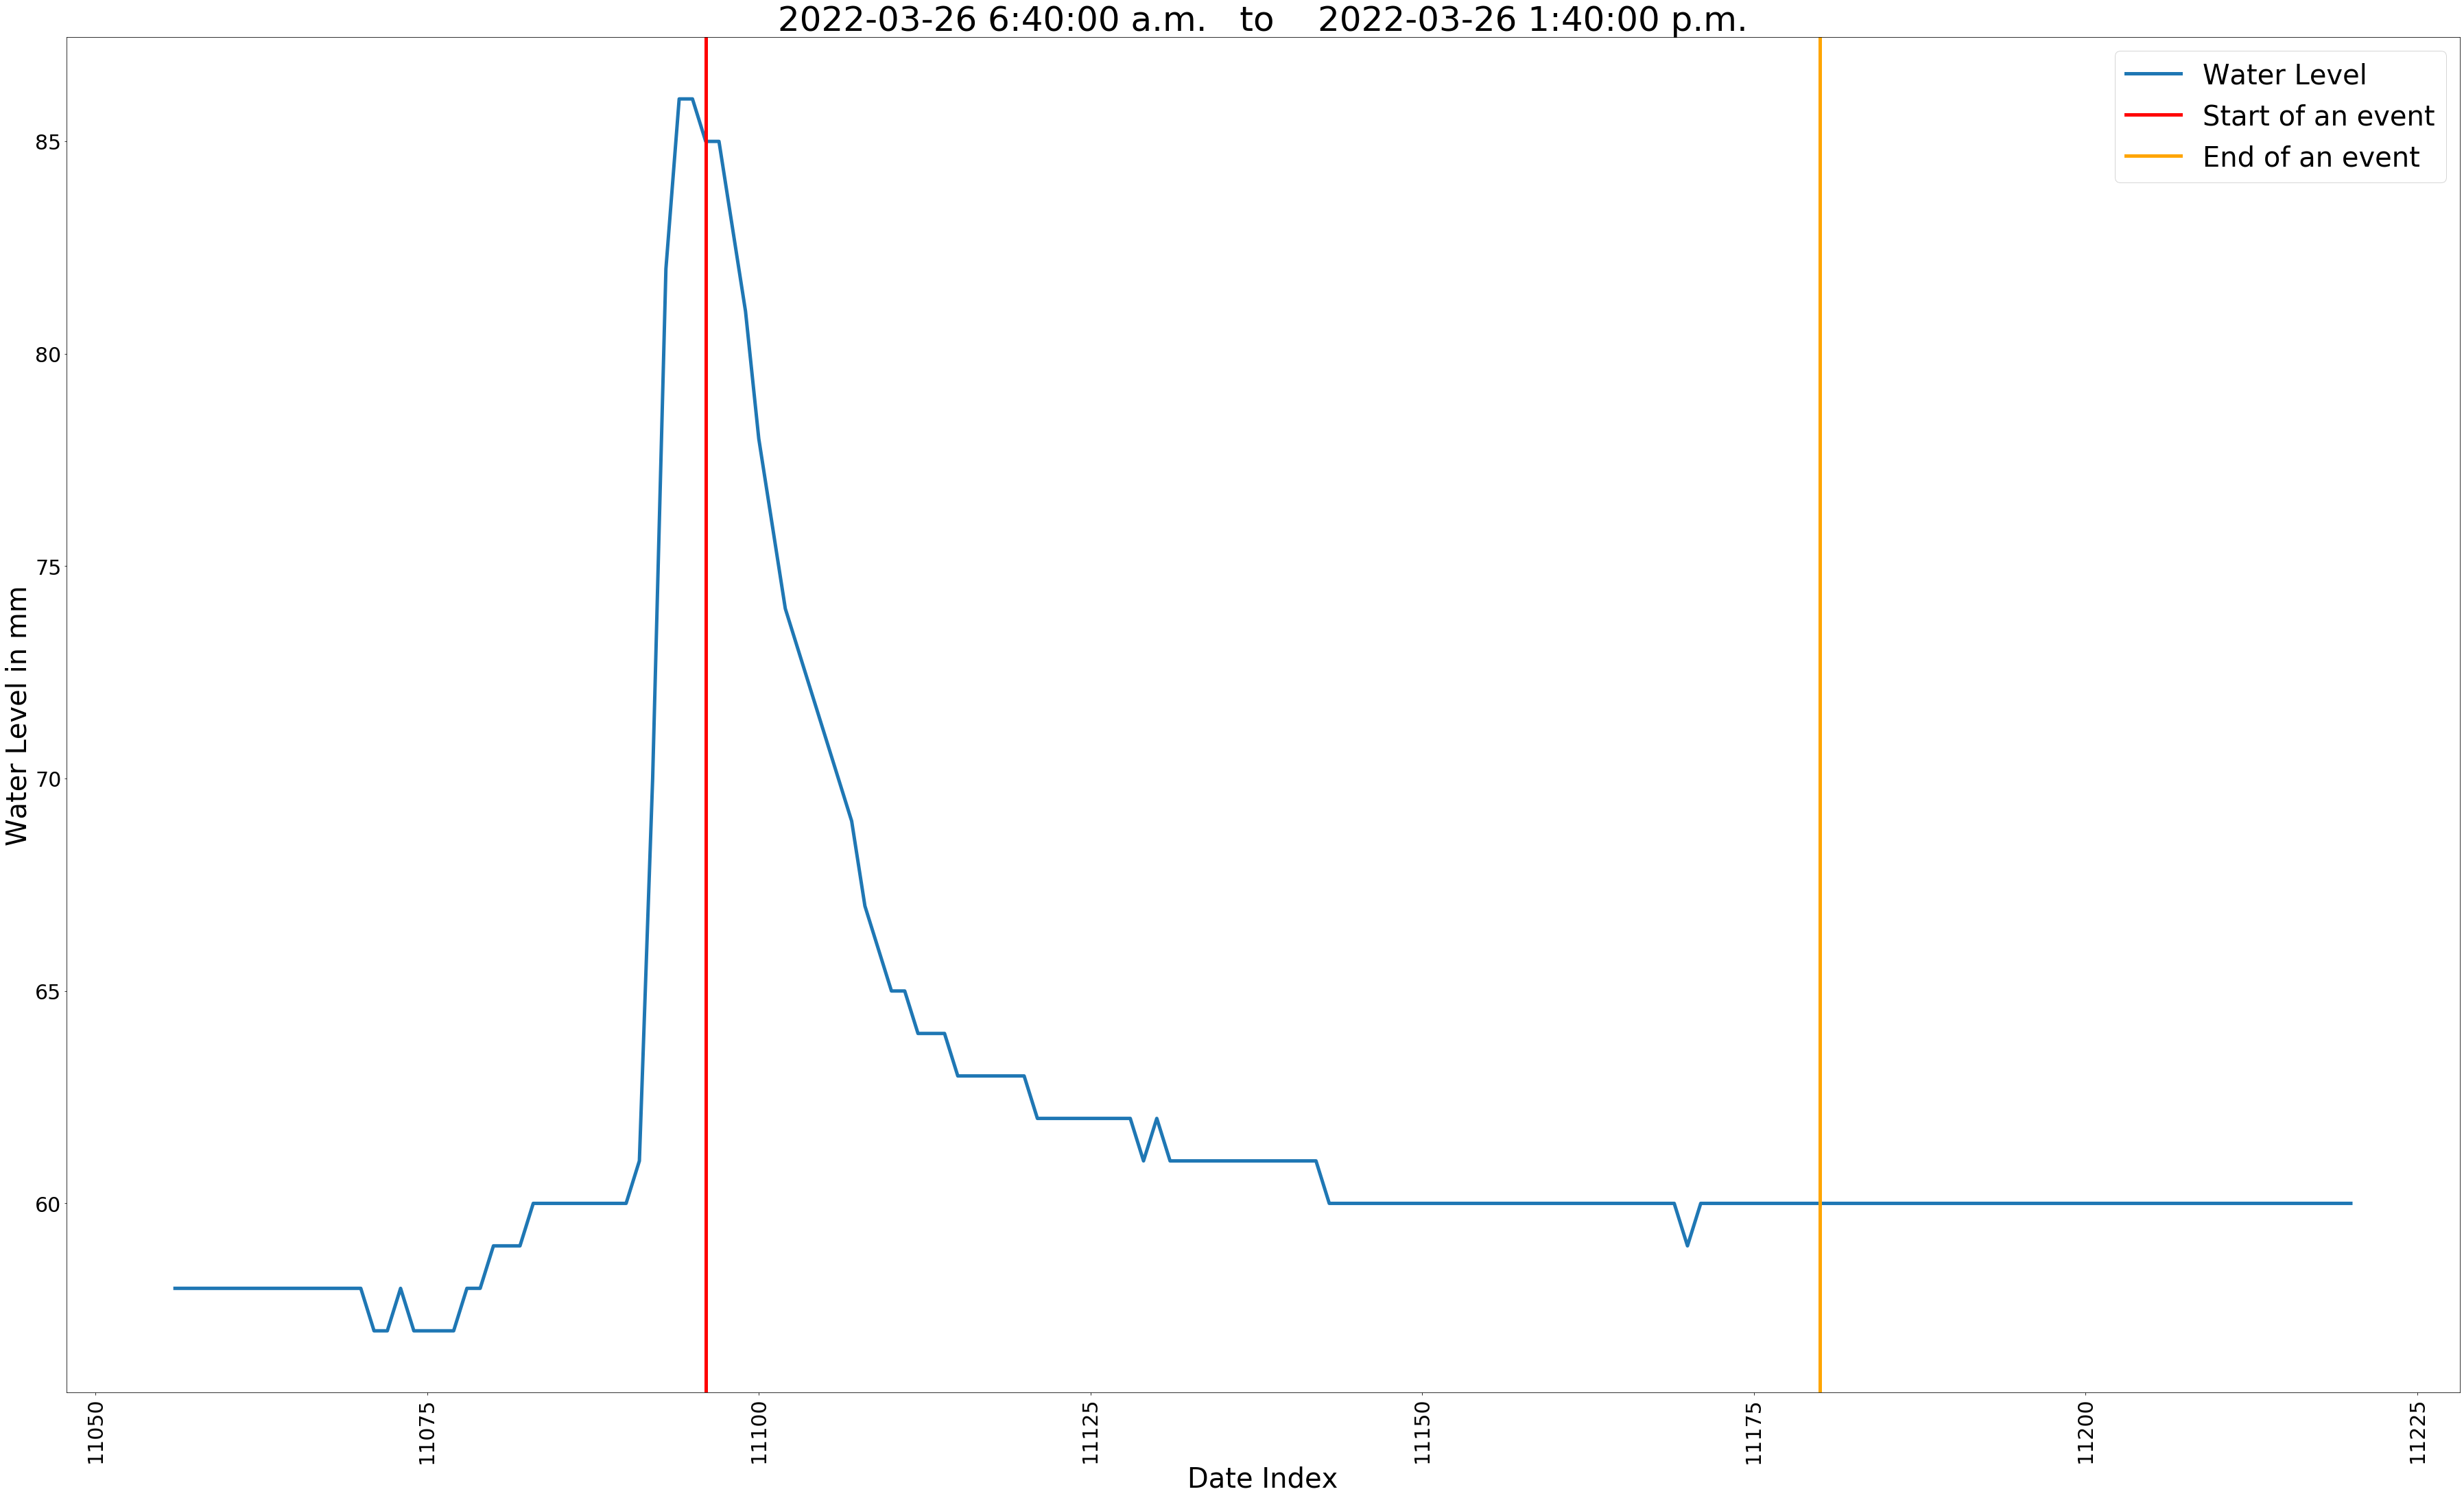

In [881]:
# Let's see a particular !Rainfall event
buffer=40
index=11
#X=Timestamp[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer+1]
X=range(start_indexB[index]-buffer,end_indexB[index]+buffer+1)
Y=water_levelB[rf_eventB["Rainfall_start_index"][index]-buffer:rf_eventB["Rainfall_end_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexB[index],linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexB[index],linewidth=5, color='orange',label="End of an event")
plt.title('Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.tight_layout()
plt.title(start_timeB[index]+"   to    "+end_timeB[index],fontsize=50)
plt.show()

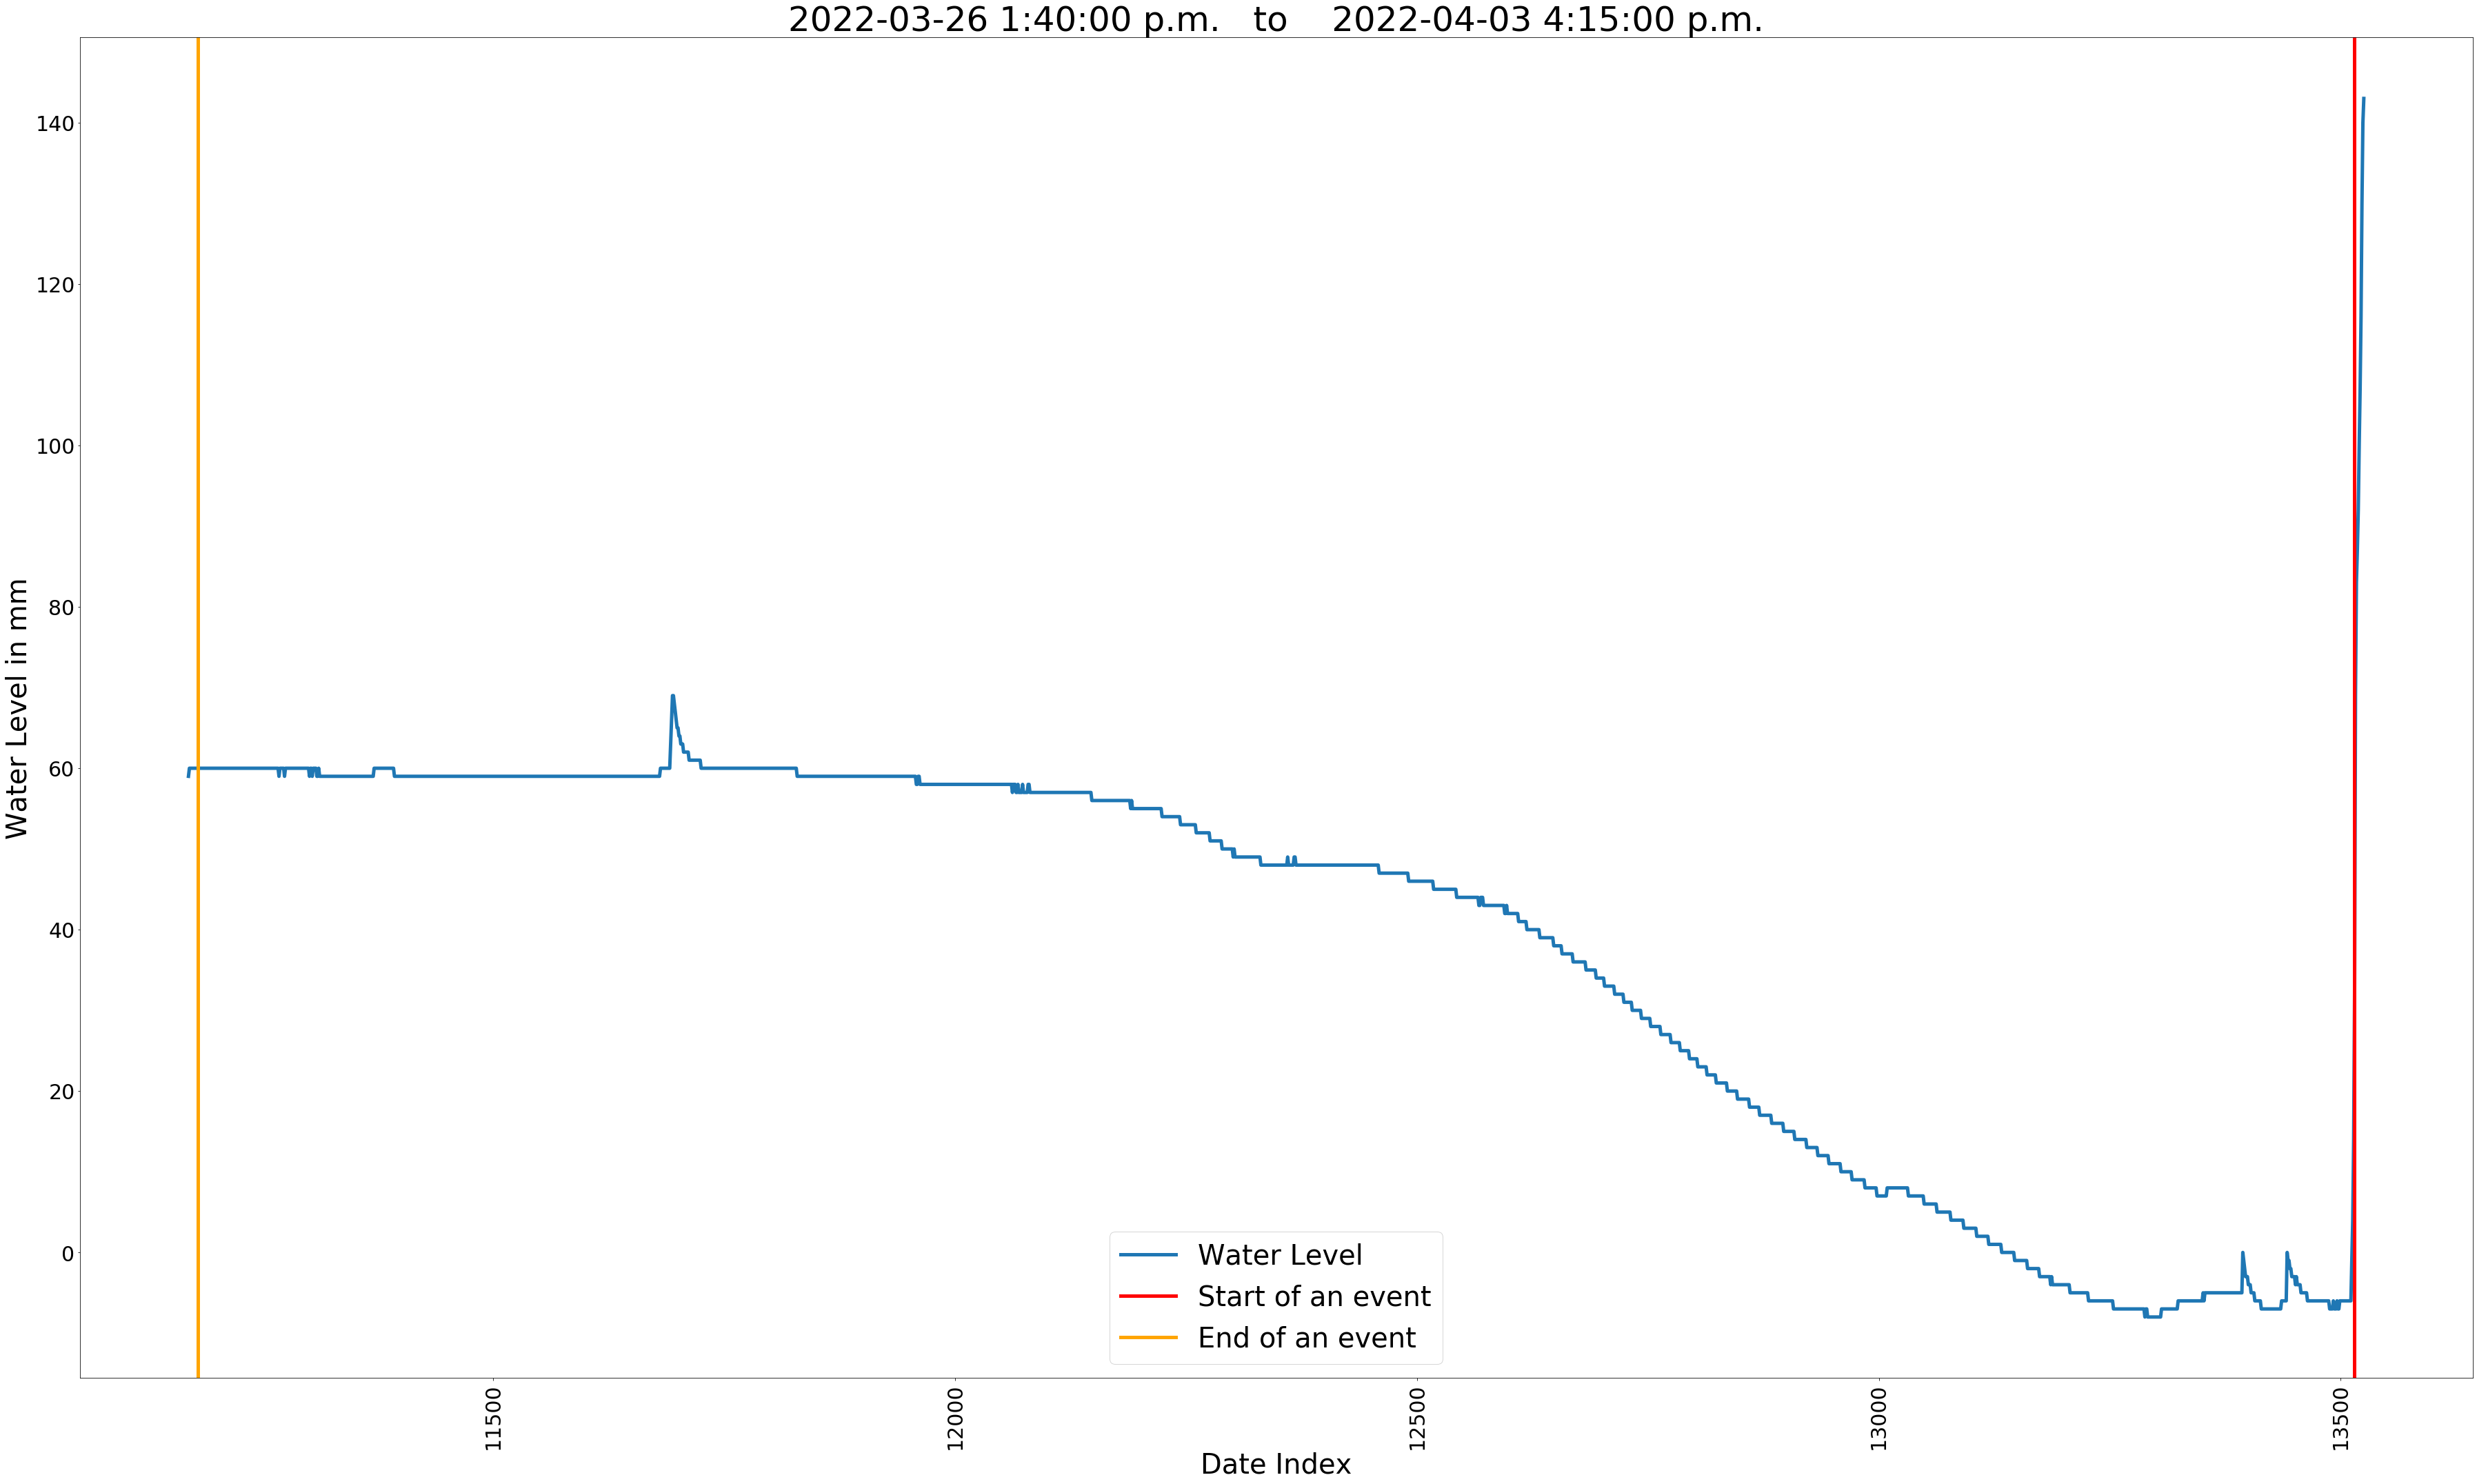

In [659]:
# Let's look at a particular No !Rainfall event
buffer=10
index=8
X=range(end_indexB[index-1]-buffer,start_indexB[index]+buffer+1)
Y=water_levelB[rf_eventB["Rainfall_end_index"][index-1]-buffer:rf_eventB["Rainfall_start_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexB[index], linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexB[index-1],linewidth=5, color='orange',label="End of an event")
plt.title('No Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.title(end_timeB[index-1]+"   to    "+start_timeB[index],fontsize=50)
plt.tight_layout()
plt.show()